In [2]:
# library import
import random
from os.path import isfile
import numpy as np
import gym
from abc import ABC, abstractmethod
from collections import defaultdict, namedtuple, deque
import matplotlib.pyplot as plt
from keras import Sequential, Input
from keras.activations import relu, linear
from keras.layers import Dense, Dropout, Flatten
from keras.losses import mse, huber_loss
import tensorflow as tf
from keras.optimizers import Adam
from scipy.stats import norm
import math
import json
import seaborn as sns
import pandas as pd
from itertools import count
import torch
import matplotlib

# 1. Environment

Author:
* Fangji Chen(200520598)
* Cheuk Ying Iu(200514612) 
* Harini Anand(200525035)

In [3]:
class EnvCartPole:
    def __init__(self, discretize=False, discrete_base=None, new_step_api=True):

        # set new_step_api in class EnvCartPole
        self.new_step_api = new_step_api

        # check for compatibility or not
        if new_step_api:
            # create gym environment (with compatibility functions)
            self._env = gym.make("CartPole-v1", new_step_api=new_step_api)
        else:
            # create gym environment
            self._env = gym.make("CartPole-v1")

        # set characteristics of the action space of the environment
        self.n_actions = self._env.action_space.n
        # set structure of the observations of the environment (shape)
        self.n_observation_space = self._env.observation_space.shape[0]
        # set discrete base
        self.base = discrete_base
        # set discretize
        self.discretize = discretize
        pass

    # produce the correct format of actions for the environment
    def sample_action(self):
        return self._env.action_space.sample()

    @staticmethod
    # calculation of discretizing
    def norm_spacing(x, lim, base):
        """
        see example of discretizing:
        for x in np.arange(-lim, lim, 0.1):
            print("x=%.1f, bin id: %d" % (x, math.ceil(norm.cdf(x / lim * 3) * base) - 1))
        """
        # debugging
        assert (abs(x) <= lim)

        # math.isinf --> check infinite
        # math.ceil --> round up to nearest integer
        # cdf --> cumulative distribution function

        if math.isinf(lim):
            # discretizing calculation (infinite)
            b = math.ceil(norm.cdf(x) * base) - 1
        else:
            # discretizing calculation (not infinite)
            b = math.ceil(norm.cdf(x / lim * 3) * base) - 1
        
        # b is larger than or equal to 0 than return b
        # b is smaller than 0 than return 0
        return b if b >= 0 else 0

    # discretize
    def state_discretize(self, s):
        """
        See definition of observation-space:
        https://www.gymlibrary.dev/environments/classic_control/cart_pole/#observation-space
        """

        # set Cart_Position, Cart_Velocity, Pole_Angle, Pole_Angular_Velocity
        [Cart_Position, Cart_Velocity, Pole_Angle, Pole_Angular_Velocity] = s

        # Cart_Position --> Cart's current position (in meters)
        # Cart_Velocity --> Cart's current velocity (in meters/second)
        # Pole_Angle --> Pole's current angle (in radians)
        # Pole_Angular_Velocity --> Pole's current angular velocity (in radians/second)

        # set array with function norm_spacing (type = integer)
        bins = np.array([
            # math.pow --> return value in power of y (xy)
            # np.inf --> representation of positive infinity (floating)
            self.norm_spacing(Cart_Position, 4.8, self.base) * math.pow(self.base, 3),
            self.norm_spacing(Cart_Velocity, np.inf, self.base) * math.pow(self.base, 2),
            self.norm_spacing(Pole_Angle, 0.418, self.base) * math.pow(self.base, 1),
            self.norm_spacing(Pole_Angular_Velocity, np.inf, self.base) * math.pow(self.base, 0),
        ], dtype=int)

        # print("current bin id: ", bins.sum())

        # return sum of bins (in String)
        return str(bins.sum())

    # reset
    def reset(self):
        # Reset the environment to the initial state
        s = self._env.reset()

        # check discretize
        if self.discretize:
            return self.state_discretize(s)
        else:
            # isinstance--> check if the specified object is in the specified type or not
            # check s[1] = dict && s[0] = np.ndarray
            if isinstance(s[1], dict) and isinstance(s[0], np.ndarray):
                return np.array([s[0]])
            else:
                return np.array([s])

    # step
    def step(self, a, new_reward=False):
        """
        SEE API definition: https://github.com/openai/gym/blob/master/gym/core.py
        """
        # check for compatibility or not
        if self.new_step_api:
            # Updates the environment with the actions which returning in the observation of the next agent
            # with 4 value
            s_, r, terminated, truncated = self._env.step(a)[:4]
        else:
            # Updates the environment with the actions which returning in the observation of the next agent
            # with 3 value
            s_, r, terminated = self._env.step(a)[:3]
            # set truncated
            truncated = False

        # check discretize
        if self.discretize:
            # Applying discretization to s' with function state_discretize
            s_ = self.state_discretize(s_) 
        else:
            # Create array
            # or 
            s_ = np.array([s_])

        # check new_reward
        if new_reward:
            # instead of the default setting, only a punishment will return when failed, otherwise 0.
            r = -1 if terminated else 0

        return s_, r, terminated, truncated


## 1.1. Let's have a look at the states of environment

### 1.1.1. State in a 2-D array as default

In [ ]:
# set environment with EnvCartPole class (new_step_api = True && discretize = False)
env = EnvCartPole(new_step_api=True, discretize=False)

# range 10
for i in range(10):
    # generating a contious state as a 2-D array
    print(env.reset())

[[0.00568283 0.04427578 0.0038558  0.03942027]]
[[ 0.0248539  -0.0005371   0.02523008 -0.01653448]]
[[-0.0122786   0.02840434 -0.00181291 -0.01469856]]
[[ 0.04707563 -0.01799884 -0.0003169  -0.00170915]]
[[-0.00401203  0.00871859 -0.02288651 -0.02112564]]
[[-0.04804464 -0.03758281 -0.01859241 -0.04134453]]
[[0.00012766 0.00118646 0.03224208 0.02911781]]
[[ 0.04045567  0.0027198   0.04897704 -0.03004796]]
[[ 0.04180244 -0.0366092   0.03809243  0.02065346]]
[[0.00464131 0.04927104 0.03364421 0.00571359]]


### 1.1.2. Stete in scalar

In [ ]:
# set environment with EnvCartPole class (new_step_api = True && discretize = True && discrete_base = 10)
env = EnvCartPole(new_step_api=True, discretize=True, discrete_base=10)

# range 10
for i in range(10):
    # a discretized state as a scalar
    print(env.reset())

4535
4535
5434
5554
4465
5555
5545
5435
4565
5465


## 1.2. Mapping and discritizing of a contious state

States in the center of its range are with higher probability. Here is the visualization of how `norm_spacing()` works for an individual state observation.

x=-4.8, bin id: 0
x=-2.1, bin id: 1
x=-1.3, bin id: 2
x=-0.8, bin id: 3
x=-0.4, bin id: 4
x=0.0, bin id: 5
x=0.4, bin id: 6
x=0.8, bin id: 7
x=1.3, bin id: 8
x=2.1, bin id: 9
x=4.8, bin id: 9


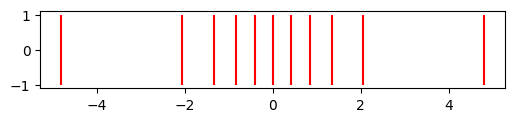

In [ ]:
base = 10
bound, bin = 4.8, -1
lst = []

# np.arange --> evenly spaced values within a given interval
for x in np.arange(-bound, bound, 0.01):
    
    # math.ceil --> round up to nearest integer
    # cdf --> cumulative distribution function

    # discretizing calculation
    new_bin = math.ceil(norm.cdf(x / bound * 3) * base) - 1

    # check new_bin larger than bin
    if new_bin > bin:
        # append() --> appends the element to end of the list
        lst.append(x)
        # set new_bin to bin
        bin = new_bin
        print("x=%.1f, bin id: %d" % (x, new_bin))

print("x=%.1f, bin id: %d" % (bound, bin))

# append() --> appends the element to end of the list
lst.append(bound)

# Plot vertical lines in figsize = (6, 1), ymin = -1, ymax = 1 and color = red
plt.figure(figsize=(6, 1))
plt.vlines(lst, -1, 1, color="red")

## 1.3. Returns of `env.action()`

In [ ]:
from itertools import count

# create gym environment
# debugging new step API
env = gym.make("CartPole-v1", new_step_api=True)
# Reset the environment to the initial state
env.reset()
# creates a set
s = set()

# range 1000
for i in range(1000):
    # Updates the environment with the actions which returning in the observation of the next agent
    # with 5 value
    observation, reward, terminated, truncated, _ = env.step(0)
    # adds new element to the set
    s.add((terminated, truncated))
    
print(i)
# truncated can be used to end the episode prematurely before a `terminal state` is reached.
print(s)

999
{(True, False), (True, True), (False, False)}


/usr/local/lib/python3.9/dist-packages/gym/envs/classic_control/cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


# 2. Agent

Author:
* Fangji Chen(200520598)
* Cheuk Ying Iu(200514612) 
* Harini Anand(200525035)

A defination of an agent contains some params to record its runtime and some behaviors to act.

In [4]:
class Agent:
    def __init__(self, environment, n_episodes=1, n_steps=1, gamma=0.5, alpha=0.5,
                 epsilon=None, epsilon_start=0.95, epsilon_end=0.05, epsilon_decay=1.0e+05, checkpoint_name=None):
        self.env = environment  # to interact with the environment through the 'env' attribute
        self.n_actions = self.env.n_actions # Assigns number of actions available
        self.n_obs_space = self.env.n_observation_space # sets the number of observation space dimensions in the environment to the attribute of the Agent
        self.dynamic_e_greedy = True if epsilon is None else False # Setting the `dynamic_e_greedy` attribute of the Agent instance to true with conditions
        self.epsilon = epsilon  # static e-greedy hyperparameter, default None
        self.epsilon_start = epsilon_start  # dynamic e-greedy params
        self.epsilon_end = epsilon_end  # dynamic e-greedy params
        self.epsilon_decay = epsilon_decay  # dynamic e-greedy params
        self.g = gamma # Assigning the discount factor gamma
        self.lr = alpha # Assigning the learning rate
        self.n_episodes = n_episodes # Assigning the number of episodes
        self.n_steps = n_steps # Assigning the number of steps
        self.Q = defaultdict(lambda: [0] * self.n_actions) # Initializing the Q-table as default dictionary with values 0 for each action. Q table is used to estimate the expected future rewards for each action in all possible states.
        self.steps = [] # Initializing an empty list to store number of steps taken at each episode during training.
        self.sum_steps = 0 # Setting the total number of steps taken during training to 0.
        self.checkpoint_name = checkpoint_name # Assigning a name for the checkpoint file to be used during training.
        self.policy_net, self.target_net = None, None # This lets us save the current state of Q-table so that we can resume training later if needed.
        pass
    
    @abstractmethod
    # Define learning function for the agent learning from sars_
    def learning(self, s, a, r, s_, d):
        pass

    @abstractmethod
    # Define move function for the agent
    def action(self, s):
        pass

    def keep_running(self, new_r=False, debugging_freq=1000):
        # read checkpoint
        self.read_policy()
        self.run(new_r=new_r, debugging_freq=debugging_freq)

    @abstractmethod
    # The code below runs the agent for a specified number of episodes and steps.
    def run(self, new_r=False, debugging_freq=1000):
        pass

    @abstractmethod
    # The below code tests the agent in the environment after training.
    def test(self, new_r=False):
        pass

    # The funtion saves the training runtime environments into a checkpoint file
    def save_policy(self):
        checkpoint = {"Q": self.Q, "steps": self.steps, "epsilon": self.epsilon, "dynamic_epsilon": self.dynamic_e_greedy}
        # print("save_policy: ", checkpoint)
        open('./' + self.checkpoint_name + '.json', 'w').write(json.dumps(checkpoint))
        # print("save runtime environments")

        # save() --> save array to the binary file in NumPy

        # check policy_net is not None
        if self.policy_net is not None:
            self.policy_net.save("%s/%s/" % (self.checkpoint_name, self.policy_net._name))
            # print("save policy_net")

        # check target_net is not None
        if self.target_net is not None:
            self.target_net.save("%s/%s/" % (self.checkpoint_name, self.target_net._name))
            # print("save target_net")
        pass
    
    # The function reads the saved checkpoint from a file and loads the saved weights of keras models.
    def read_policy(self):
        try:
            # json.loads() --> parse the JSON string & convert into the Python Dictionary
            # read() --> get bytes specified number from the file
            checkpoint = json.loads(open('./' + self.checkpoint_name + '.json', 'r').read())
            self.Q = defaultdict(lambda: [0] * self.n_actions, checkpoint["Q"])
            self.steps = checkpoint["steps"]
            self.sum_steps = np.array(self.steps).sum()

            # Checking to see if using dynamic epsilon-greedy, update epsilon value from checkpoint
            if self.dynamic_e_greedy and checkpoint["dynamic_epsilon"]:
                self.dynamic_e_greedy = checkpoint["dynamic_epsilon"]
                self.epsilon = checkpoint["epsilon"]
            print('read checkpoint from ./' + self.checkpoint_name + '.json')

            # check policy_net is not None
            if self.policy_net is not None:
                path = "%s/%s/" % (self.checkpoint_name, self.policy_net._name)
                # isfile() --> check if the path is existing regular file
                if isfile(path):
                    # load policy_net
                    self.policy_net.load_weights(path)
                    print("load weights to policy_net")

            # check target_net is not None
            if self.target_net is not None:
                path = "%s/%s/" % (self.checkpoint_name, self.target_net._name)
                # isfile() --> check if the path is existing regular file
                if isfile(path):
                    # load target_net
                    self.target_net.load_weights(path)
                    print("load weights to target_net")

            print("Epsilon starts from %.4f" % (self.epsilon_start if self.epsilon is None else self.epsilon))
            
        # Catching any exceptions that may occur during reading.
        except Exception as e:
            # printing the error message
            print("skip from reading checkpoint: ", self.checkpoint_name)
            print(e)
            pass

    # plot for cumsum
    def cumsum_plot(self, random_step, smart_steps, last_n_steps=0):
        # np.cumsum --> cumulative sum
        # use np.cumsum to compute accumulate steps for each episode
        # 2 dimensional data structure
        f = pd.DataFrame({"Random Agent": np.cumsum(random_step)[last_n_steps:],
                          "Smart Agent": np.cumsum(smart_steps)[last_n_steps:],
                          })
        # stack and plot
        f = self.dataframe_stack(f)
        # function vis
        self.vis(f, title='Accumulation Steps', x_label='Episodes', y_label='Steps', save_file='./cum_steps.jpg')
    
    # to generate a visualization of the learning progress over time
    def rolling_plot(self, last_n_steps=0):
        # 2 dimensional data structure
        f = pd.DataFrame({"Steps": self.steps[last_n_steps:]})
        # Calculating the moving avg of the last 100 episodes
        f['MA_100'] = f['Steps'].rolling(100).mean()
        # stack and plot
        f = self.dataframe_stack(f)
        # function vis
        self.vis(f, title='Rolling Steps', x_label='Episodes', y_label='Steps', save_file='./rolling_steps.jpg')

    @staticmethod
    # stack a dataframe
    def dataframe_stack(f): 
        # Replace NaN values with float 0., this happens when calculate rolling mean for a series
        f.fillna(0.0)
        # stack() --> Stack prescribed level (from columns to index)
        # reset_index() --> Reset the index
        f = f.stack().reset_index()
        # set columns
        f.columns = ["x", "hue", "y"]
        return f

    @staticmethod
    # to generate a visualization of the learning progress over time
    def vis(data, title, x_label, y_label, save_file):
        # Create a figure with the set of subplots
        fig, ax = plt.subplots(1, 1, figsize=(10, 3), dpi=100)

        # lineplot
        sns.lineplot(data=data, x="x", y="y", hue="hue", markers=False, dashes=False, lw=1, ax=ax)

        ax.set_title(title)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.set_yscale('log') # change y axis to log scale to show more details when line plots are differ by orders of magnitude
        ax.grid(color='black', linestyle='--', which='major', linewidth=0.5) # major grids
        ax.grid(color='gray', linestyle='--', which='minor', linewidth=0.3) # minor grids
        ax.legend()
        plt.tight_layout()
        plt.savefig(save_file)
        plt.show()



# 3. Q-learning Agent Implementation

Author:
* Fangji Chen(200520598)
* Cheuk Ying Iu(200514612) 
* Harini Anand(200525035)

The expected optimal policy $E[Q(s,a)]$ can be defined as $max_a[Q(s',A)]$ as shown in equation 4.9.

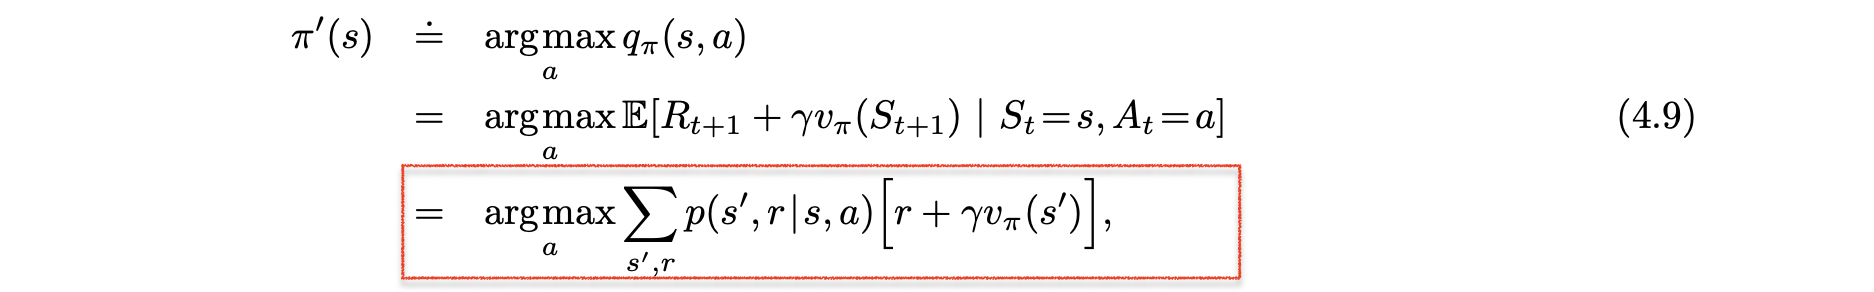

Thus we can defines an optimizating process by reducing the error between `Expectation` and `Observations` by **TD-Control** in equation 6.2: the smaller the diff is the better the policy will be.

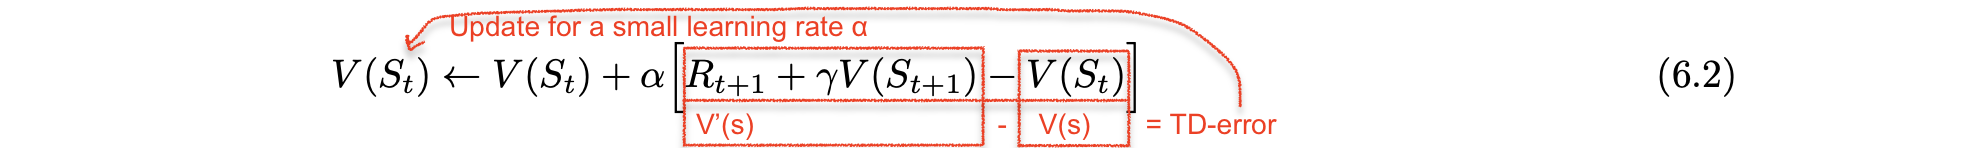

A backup diagram is helpful to better understand this optimazation process.

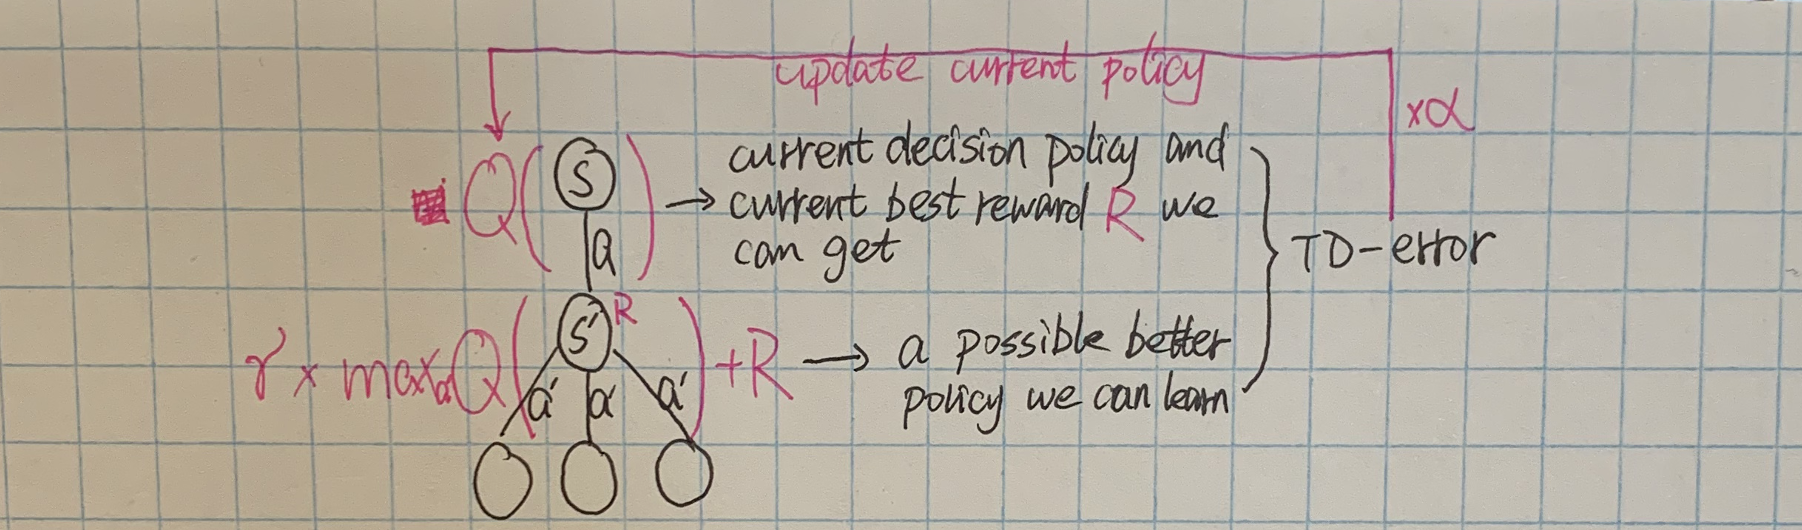

In order to complete this optimization process, we need a table to store every possible action in every possible state. This is called a Q-table: which is going to be used as `the Policy Q`.

A Q-table helps us to find the best action for each state in the environment. We use the `Bellman Equation` at each state to get the expected future state and reward and save it in a table to compare with other states.

Here is the Q-learning algorithm.

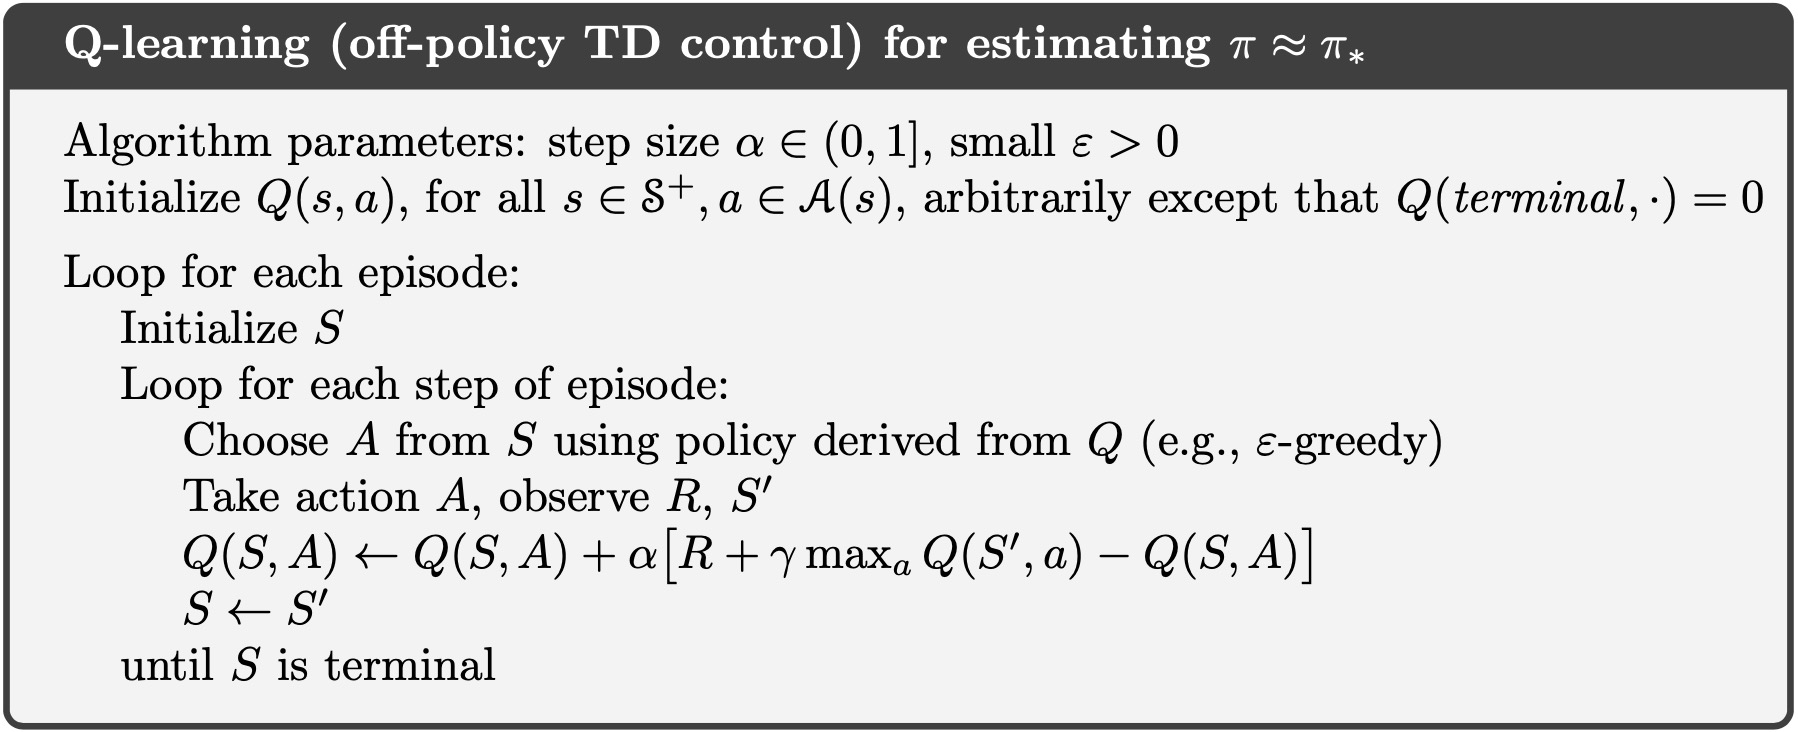

## 3.1. Q-learning Algorithm Implementation

In [5]:
class QAgent(Agent, ABC):
    def __init__(self, environment, n_episodes=1, n_steps=1, gamma=0.5, alpha=0.5,
                 epsilon=None, epsilon_start=0.95, epsilon_end=0.05, epsilon_decay=1.0e+05,
                 checkpoint_name="policy3", ):
        super().__init__(environment, n_episodes, n_steps, gamma, alpha,
                         epsilon, epsilon_start, epsilon_end, epsilon_decay, checkpoint_name)
        
        # Q-Learning Algorithm will fail in an environment with infinity states
        # Reasonable discretization method is a must for a Q-Learning Agent to work
        self.env.discretize = True  # set the env act as discretized
        pass

    def action(self, state):  # ------------------------------------------------ epsilon-greedy action policy
        if self.dynamic_e_greedy:  # ------------------------------------------- dynamic e-greedy
            self.epsilon = self.epsilon_end + (self.epsilon_start - self.epsilon_end) * math.exp(-1. * self.sum_steps / self.epsilon_decay)
        self.sum_steps += 1 # change the calculate factor to reduce epsilon from START probabiliity to END probability

        if np.random.uniform(low=0.0, high=1.0) < self.epsilon:  # ------------- epsilon exploration
            return self.env.sample_action()
        else:  # --------------------------------------------------------------- or greedy exploitation
            return np.argmax(self.Q[state][:]) # choose current best action of all possible actions

    # update q-table with bellman equation
    def learning(self, s, a, r, s_, d):
        self.Q[s][a] += self.lr * (r + self.g * max(self.Q[s_][:]) - self.Q[s][a])

    def run(self, new_r=False, debugging_freq=1000):  # --------------------------  Q-Learning (off-policy TD control) for estimating π≈π*
        for episode in range(1, self.n_episodes + 1):  # -----------------------  Loop for each episode
            s = self.env.reset()  # --------------------------------------------     Initialize S
            for step in range(1, self.n_steps + 1):  # -------------------------     Loop for each step of episode
                a = self.action(s)  # ------------------------------------------        Choose A from S using policy derived from Q (e.g., ε-greedy)
                s_, r, done, trunc = self.env.step(a, new_reward=new_r)  # -----        Take action A, observe R, S'
                self.learning(s, a, r, s_, done)  # ----------------------------        Q(S, A) = Q(S, A) + α[R + γ max Q(S', a) - Q(S, A)]
                s = s_  # ------------------------------------------------------        S = S'
                if done:  # ----------------------------------------------------     until S is terminal
                    self.steps.append(step) # save action result for each episode 
                    if episode % debugging_freq == 0:  # print the runtime informations every 50 episodes
                        print("[%d/%d]: %d, %.4f" % (episode, self.n_episodes, step, self.epsilon))
                    if episode % 100 == 0:  # save the runtime environment parameters every 100 episodes
                        self.save_policy()
                    break
        pass

    # test
    def test(self, new_r=False):
        # read policy from checkpoint
        self.read_policy()
        self.steps = []

        # Loop for each episode
        for episode in range(1, self.n_episodes + 1):
            # Initialize S
            # Reset the environment to the initial state
            s = self.env.reset()

            # count() --> the number of elements
            for step in count():
                # Choose A from S using policy derived from Q (e.g., ε-greedy)
                a = self.action(s)
                # Updates the environment with the actions which returning in the observation of the next agent
                # with 4 value
                # directly use s=s_
                s, _, done, trunc = self.env.step(a, new_reward=new_r)

                # until S is terminal
                if done or trunc:
                    # append() --> appends the element to end of the list
                    self.steps.append(step + 1)
                    break
                
        return self.steps


## 3.2. Training a Q-learning agent with a fixed e-greedy policy = 1 with 3000 episodes

e=1 means this is a total random walking agent

[50/3000]: 35, 1.0000
[100/3000]: 13, 1.0000
[150/3000]: 19, 1.0000
[200/3000]: 22, 1.0000
[250/3000]: 44, 1.0000
[300/3000]: 22, 1.0000
[350/3000]: 18, 1.0000
[400/3000]: 18, 1.0000
[450/3000]: 16, 1.0000
[500/3000]: 37, 1.0000
[550/3000]: 21, 1.0000
[600/3000]: 16, 1.0000
[650/3000]: 11, 1.0000
[700/3000]: 35, 1.0000
[750/3000]: 19, 1.0000
[800/3000]: 14, 1.0000
[850/3000]: 11, 1.0000
[900/3000]: 15, 1.0000
[950/3000]: 19, 1.0000
[1000/3000]: 13, 1.0000
[1050/3000]: 13, 1.0000
[1100/3000]: 24, 1.0000
[1150/3000]: 17, 1.0000
[1200/3000]: 44, 1.0000
[1250/3000]: 14, 1.0000
[1300/3000]: 19, 1.0000
[1350/3000]: 17, 1.0000
[1400/3000]: 18, 1.0000
[1450/3000]: 24, 1.0000
[1500/3000]: 14, 1.0000
[1550/3000]: 16, 1.0000
[1600/3000]: 25, 1.0000
[1650/3000]: 31, 1.0000
[1700/3000]: 13, 1.0000
[1750/3000]: 24, 1.0000
[1800/3000]: 21, 1.0000
[1850/3000]: 12, 1.0000
[1900/3000]: 39, 1.0000
[1950/3000]: 26, 1.0000
[2000/3000]: 12, 1.0000
[2050/3000]: 20, 1.0000
[2100/3000]: 11, 1.0000
[2150/3000]:

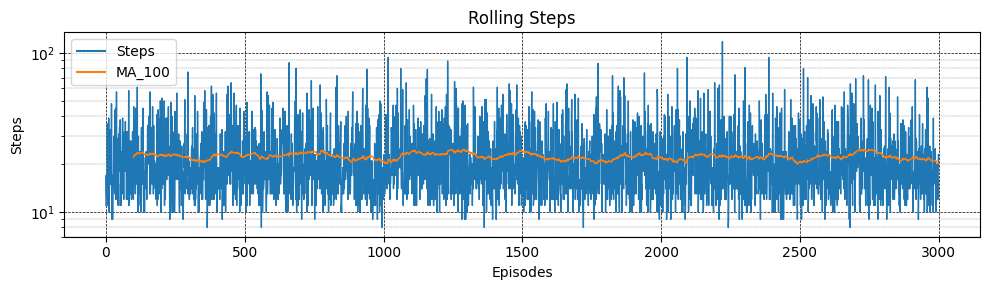

In [ ]:
# initiate CartPole environment with 8^4 discrete state spaces
env = EnvCartPole(discrete_base=8, new_step_api=True)
agent1 = QAgent(env, n_episodes=3000, n_steps=1000, gamma=0.99, alpha=0.5, epsilon=1, # 100% random move
                checkpoint_name="policy1", )
# The Q-Learning (off-policy TD control) for estimating π≈π*
agent1.run(new_r=False)
# plot moving average for each episodes of training
agent1.rolling_plot()

## 3.3. Training a Q-learning agent with a dynamic e-greedy policy with 3000 episodes

Epsilon starts from 0.9500
[50/3000]: 26, 0.9270
[100/3000]: 16, 0.9057
[150/3000]: 14, 0.8816
[200/3000]: 12, 0.8615
[250/3000]: 24, 0.8431
[300/3000]: 23, 0.8238
[350/3000]: 28, 0.8030
[400/3000]: 14, 0.7831
[450/3000]: 23, 0.7631
[500/3000]: 50, 0.7415
[550/3000]: 28, 0.7208
[600/3000]: 15, 0.7038
[650/3000]: 23, 0.6865
[700/3000]: 18, 0.6617
[750/3000]: 25, 0.6374
[800/3000]: 28, 0.6187
[850/3000]: 45, 0.5971
[900/3000]: 47, 0.5776
[950/3000]: 24, 0.5552
[1000/3000]: 36, 0.5351
[1050/3000]: 48, 0.5136
[1100/3000]: 39, 0.4936
[1150/3000]: 23, 0.4665
[1200/3000]: 106, 0.4383
[1250/3000]: 75, 0.4141
[1300/3000]: 47, 0.3853
[1350/3000]: 142, 0.3618
[1400/3000]: 30, 0.3310
[1450/3000]: 123, 0.3014
[1500/3000]: 251, 0.2725
[1550/3000]: 117, 0.2450
[1600/3000]: 165, 0.2176
[1650/3000]: 193, 0.1906
[1700/3000]: 122, 0.1689
[1750/3000]: 132, 0.1435
[1800/3000]: 263, 0.1227
[1850/3000]: 191, 0.1031
[1900/3000]: 58, 0.0847
[1950/3000]: 120, 0.0733
[2000/3000]: 111, 0.0595
[2050/3000]: 259, 0.

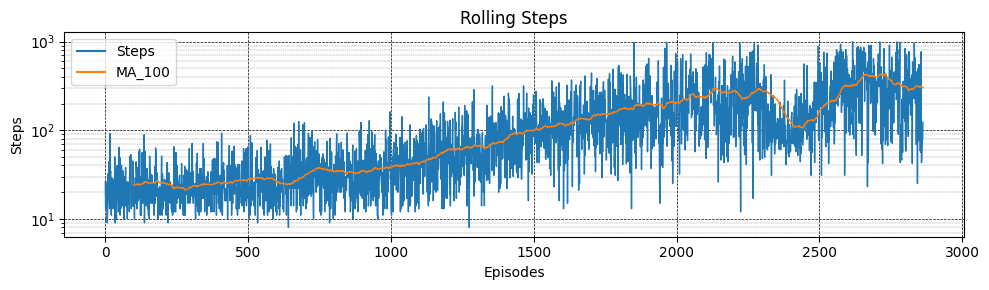

In [ ]:
# initiate CartPole environment with 10^4 discrete state spaces
env = EnvCartPole(discrete_base=10, new_step_api=True)
agent2 = QAgent(env, n_episodes=3000, n_steps=1000, gamma=0.99, alpha=0.3, epsilon=None,
                epsilon_start=0.95, epsilon_end=0.01, epsilon_decay=5.0e+04, 
                checkpoint_name="policy2", )
# The Q-Learning (off-policy TD control) for estimating π≈π*
agent2.run(new_r=False)
# plot moving average for each episodes of training
agent2.rolling_plot()

## 3.4. Q-Learning Agent Comparison

Set epsilon to 0 to apply trained Q-Table policy.

read checkpoint from ./policy1.json
Epsilon starts from 1.0000
read checkpoint from ./policy2.json
Epsilon starts from 0.0102


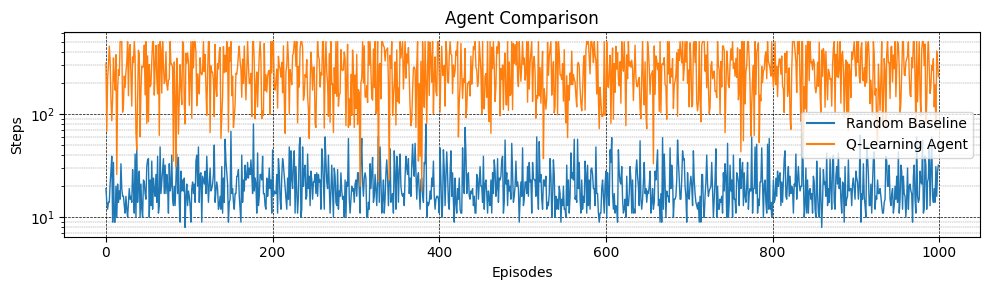

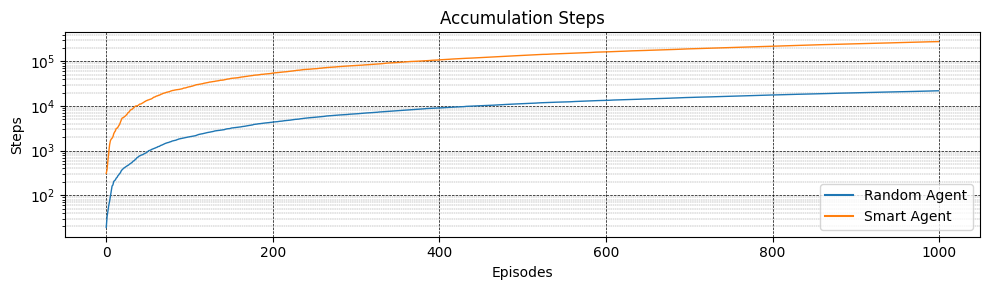

In [ ]:
# define e=0 to apply policy 1, which is a random baseline
agent1 = QAgent(env, n_episodes=1000, epsilon=0, checkpoint_name="policy1", )
test1 = agent1.test(new_r=False)

# define e=0 to apply policy 2, which is a Q-Learning Agent
agent2 = QAgent(env, n_episodes=1000, epsilon=0, checkpoint_name="policy2", )
test2 = agent2.test(new_r=False)

df = pd.DataFrame({"Random Baseline": test1[-1000:], "Q-Learning Agent": test2[-1000:]})
# stack() --> Stack prescribed level (from columns to index)
# reset_index() --> Reset the index
df = df.stack().reset_index()
df.columns = ["x", "hue", "y"]

agent2.vis(df, "Agent Comparison", "Episodes", "Steps", "Agent comparison") # plot Agent Comparison line plot
agent2.cumsum_plot(test1, test2) # plot Agent Comparison line plot with step accumulative sum


# 4. DQN Agent Implementation

Author:
* Fangji Chen(200520598)

As we know, the expected optimal policy of a state S is represented by its future action-values A. And from , we can approximate the $E[Q]$ of S by applying the best action-value of $Q(s',A)$.

Deep Q-Network considers the Optimal Policy($E[Q]$) as the ground truth and simulated it with a `Target Network` and the DQN Agent makes decisions in an environment by a `Policy Network` while learning from a collection of recent memories in each step.

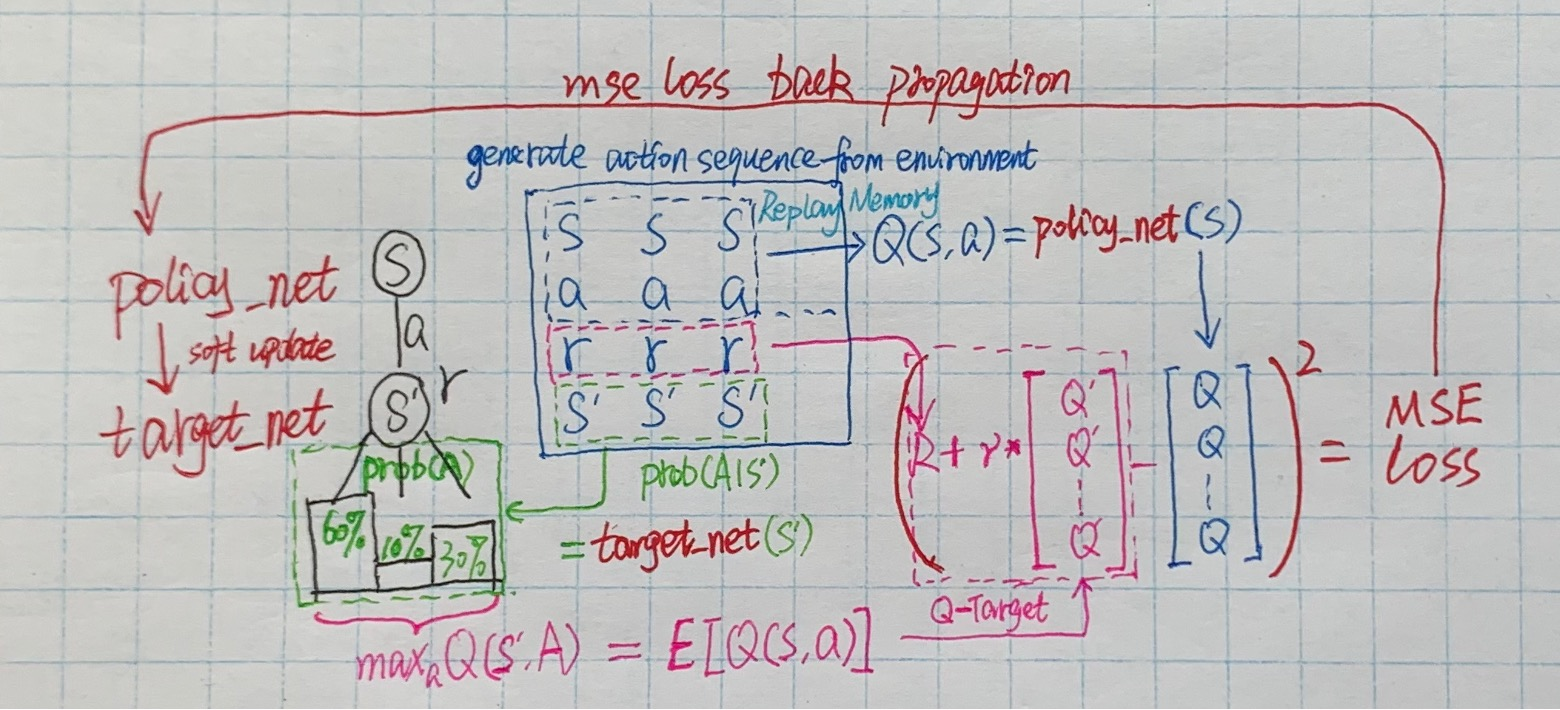

Thus the DQN architectures can be implemented with the algorithm shown below:

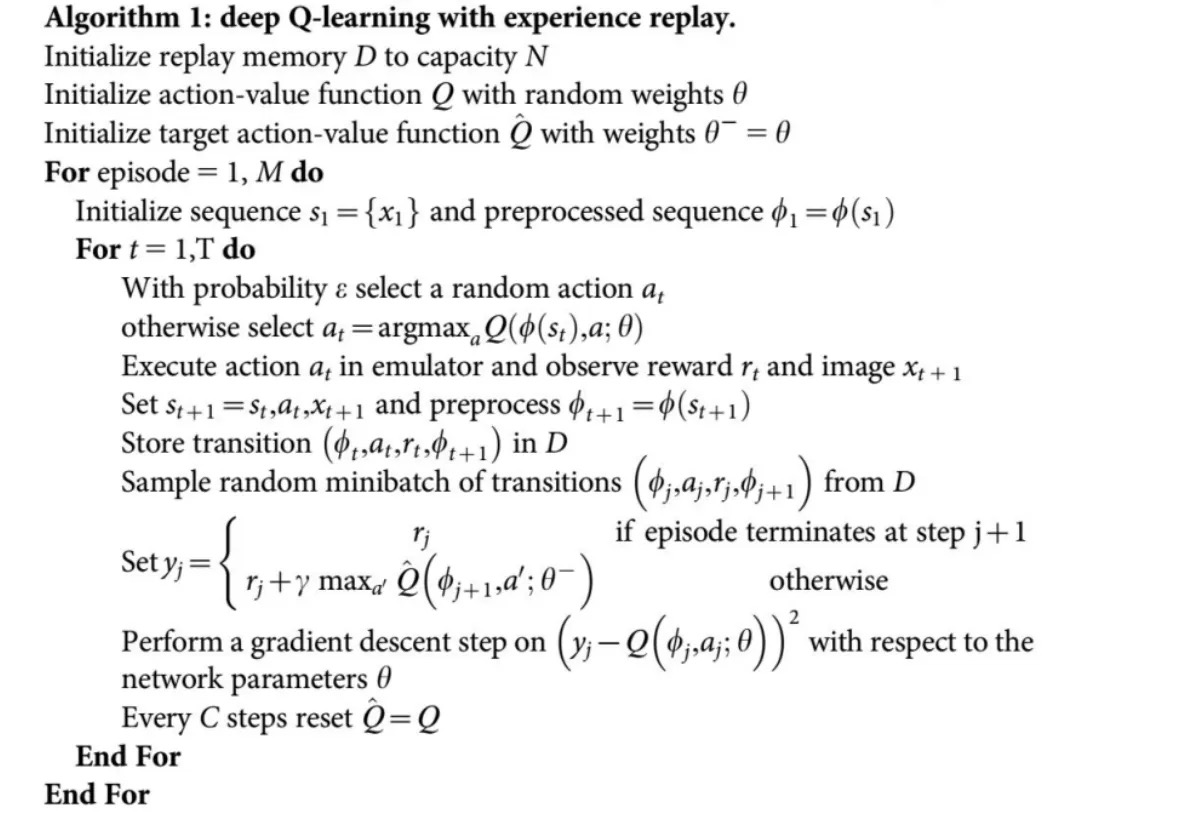

## 4.1. DQN Algorithm Implementation

In [6]:
class DQNAgent(Agent, ABC):
    def __init__(self, environment, n_episodes=1, n_steps=1, gamma=0.5,
                 memory_cap=10000, batch_size=64, alpha=1.0e-4, tau=1.,
                 epsilon=None, epsilon_start=0.95, epsilon_end=0.05, epsilon_decay=1.0e+05,
                 checkpoint_name=None, ):
        super().__init__(environment, n_episodes, n_steps, gamma, alpha,
                         epsilon, epsilon_start, epsilon_end, epsilon_decay, checkpoint_name)
        
        # DQN support a continues state space, then False
        self.env.discretize = False
        # class ExperienceReplay
        self.experiences = self.ExperienceReplay(memory_cap, batch_size, self.n_actions)
        # DNN
        self.optimizer = Adam(learning_rate=self.lr, amsgrad=True)
        self.policy_net = self.DNN("policy_net")
        self.target_net = self.DNN("target_net")
        # for a soft update if less than 1
        self.TAU = tau

    def DNN(self, model_name):
        # Creating a Sequential model
        # plain stack of layers with exactly one input tensor and one output tensor
        dnn = Sequential([
            Input(shape=(self.n_obs_space,)),  # fit output size to the observation space of environment
            Dense(128, activation="relu"),  # hidden layer 1 of a DNN
            Dense(128, activation="relu"),  # hidden layer 2 of a DNN
            Dense(self.n_actions, activation="linear") # fit output size to the action space of environment
        ])
        
        dnn.compile(loss=mse, optimizer=Adam(learning_rate=self.lr))  # compile model before use
        dnn._name = model_name # set name for checkpoint management

        return dnn

    class ExperienceReplay(object):
        def __init__(self, capacity, batch_size, n_actions):
            self.Transition = namedtuple('Transition', ('s', 'a', 'r', 's_', 'd')) # define elements of a transition
            self.batch_size = batch_size # define a batch size from outside of the class
            self.memory = deque([], maxlen=capacity)  # initiate the Double Ended QUEue with capacity length
            self.n_actions = n_actions

        def push(self, *args):
            # push a transition into memory
            # append() --> appends the element to end of the list
            self.memory.append(self.Transition(*args))

        def sample(self):
            # transitions sampling
            transitions = random.sample(self.memory, self.batch_size)
            batch = self.Transition(*zip(*transitions))  # zip transitions into a batch

            # unify data formats
            s = tf.squeeze(tf.convert_to_tensor(batch.s, dtype=tf.float32), axis=1)
            a = tf.one_hot(batch.a, self.n_actions, dtype=tf.float32)
            r = tf.convert_to_tensor(batch.r, dtype=tf.float32)
            s_ = tf.squeeze(tf.convert_to_tensor(batch.s_, dtype=tf.float32), axis=1)
            d = np.ones(self.batch_size) - tf.convert_to_tensor(batch.d, dtype=tf.float32)
            return s, a, r, s_, d

        def allow_sampling(self):
            return self.__len__() >= self.batch_size

        def __len__(self):
            return len(self.memory)

    # epsilon-greedy action policy
    def action(self, s):
        if self.dynamic_e_greedy:  # ------------------------------------------- dynamic e-greedy
            self.epsilon = self.epsilon_end + (self.epsilon_start - self.epsilon_end) * math.exp(-1. * self.sum_steps / self.epsilon_decay)
        self.sum_steps += 1 # change the calculate factor to reduce epsilon from START probabiliity to END probability

        # epsilon exploration
        if np.random.uniform(low=0.0, high=1.0) < self.epsilon:  # ------------- epsilon exploration
            return self.env.sample_action()
        else:  # --------------------------------------------------------------- or greedy exploitation
            #      np.argmax(self.Q[state][:]) # the only difference of an action between Q-Learning and DQN is this: the action comes from Q-Table or from Policy Net
            return np.argmax(self.policy_net(s))  # choose current best action of all possible actions

    def keep_running(self, new_r=False):
        # read policy from checkpoint
        self.read_policy()
        self.run(new_r=new_r)

    # keep the plot and update it during the training process
    def plot_durations(self, show_result=False):
        plt.figure(1, figsize=(10, 3), dpi=100)
        # multi-dimensional matrix
        durations_t = torch.tensor(self.steps, dtype=torch.float)

        # check show_result
        if show_result:
            plt.title('Result')
        else:
            # clear the figure
            plt.clf()
            plt.title('Training...')

        plt.xlabel('Episode')
        plt.ylabel('Duration')
        plt.plot(durations_t.numpy())

        # Take 100 episode averages and plot them too
        if len(durations_t) >= 100:
            means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
            means = torch.cat((torch.zeros(99), means))
            plt.plot(means.numpy())

        # pause a bit so that plots are updated
        plt.pause(0.001)

        if is_ipython:
            if not show_result:
                display.display(plt.gcf())
                display.clear_output(wait=True)
            else:
                display.display(plt.gcf())

    @tf.function
    def _learning(self, s, a, r, s_, mask):
        with tf.GradientTape() as g:
            real_q = tf.reduce_sum(self.policy_net(s) * a, axis=1) # use one-hot encoding action matrix as a mask to select current action-value Q(s,a)
            max_q_ = tf.reduce_max(self.target_net(s_), axis=1) # select max action-value Q(S',a') as supervise learning training labels for each row
            loss = mse(r + mask * self.g * max_q_, real_q) # calculate MSE loss between Q-targets and Q-observations
        
        # compute gradients with loss for all trainable variables
        gradients = g.gradient(loss, self.policy_net.trainable_variables) 
        # update the weights with loss with back propagation
        self.optimizer.apply_gradients(zip(gradients, self.policy_net.trainable_variables))

    def learning(self, s, a, r, s_, d):
        # ---------------------------------------------------------------------- the first step of learning is to add an observation to its memory
        self.experiences.push(s, a, r, s_, d) 
        if not self.experiences.allow_sampling():
            return
        # ---------------------------------------------------------------------- train the policy network with a batch of random selected samples
        s, a, r, s_, d = self.experiences.sample() # transitions sampling 
        self._learning(s, a, r, s_, d)
        # ---------------------------------------------------------------------- Soft update: θ′ ← τ θ + (1 −τ )θ′
        new_weights = [] # keras model weights is a python list
        w1 = self.policy_net.weights
        w2 = self.target_net.weights
        for i in range(len(w1)): 
            new_weights.append(w1[i] * self.TAU + w2[i] * (1 - self.TAU)) # soft update with the ratio self.TAU
        self.target_net.set_weights(new_weights) # sets the values of the model weights with the update
        # ---------------------------------------------------------------------- or completely replace target network with policy network every N steps:
        # if self.sum_steps % N == 0:
        #     from keras.models import clone_model
        #     self.target_net = clone_model(self.policy_net)
        pass

    def run(self, new_r=False, debugging_freq=500):  # -------------------------  Deep Q-Learning with experience replay (everything at here is the same as Q-Learning implements)
        for episode in range(1, self.n_episodes + 1):  # -----------------------  Loop for each episode
            s = self.env.reset()  # --------------------------------------------     Initialize S
            for step in range(1, self.n_steps + 1):  # -------------------------     Loop for each step of episode
                a = self.action(s)  # ------------------------------------------        Choose A from S using policy derived from Q (e.g., ε-greedy)
                s_, r, done, trunc = self.env.step(a, new_reward=new_r)  # -----        Take action A, observe R, S'
                self.learning(s, a, r, s_, done)  # ----------------------------        Training the policy network with Q-Target: R + γ max Q(S', a)
                s = s_  # ------------------------------------------------------        S = S'
                if done:  # ----------------------------------------------------     until S is terminal
                    self.steps.append(step) # save action result for each episode 
                    if episode % debugging_freq == 0:  # print the runtime informations every 20 episodes
                        # self.plot_durations()
                        print("[%d/%d]: steps %d, epsilon %.4f" % (episode, self.n_episodes, step, self.epsilon))
                    if episode % 200 == 0:  # save the runtime environment parameters every 200 episodes
                        self.save_policy()
                    break
        pass
    
    # test
    def test(self, new_r=False):
        # read policy from checkpoint
        self.read_policy()
        self.steps = [] # test result
        # Loop for each episode
        for episode in range(1, self.n_episodes + 1):
            s = self.env.reset() # Reset the environment to a random initial state
            for step in count():
                s, _, done, trunc = self.env.step(self.action(s), new_reward=new_r)
                if done or trunc:  # until S is terminal
                    self.steps.append(step + 1)
                    break
                
        return self.steps

## 4.2. Training a DQN agent with a fixed e-greedy policy = 1

This is a random baseline

[20/3000]: steps 29, epsilon 1.0000
[40/3000]: steps 23, epsilon 1.0000
[60/3000]: steps 22, epsilon 1.0000
[80/3000]: steps 29, epsilon 1.0000
[100/3000]: steps 24, epsilon 1.0000
[120/3000]: steps 28, epsilon 1.0000
[140/3000]: steps 13, epsilon 1.0000
[160/3000]: steps 23, epsilon 1.0000
[180/3000]: steps 16, epsilon 1.0000
[200/3000]: steps 26, epsilon 1.0000
INFO:tensorflow:Assets written to: policy3/policy_net/assets
INFO:tensorflow:Assets written to: policy3/target_net/assets
[220/3000]: steps 20, epsilon 1.0000
[240/3000]: steps 21, epsilon 1.0000
[260/3000]: steps 14, epsilon 1.0000
[280/3000]: steps 24, epsilon 1.0000
[300/3000]: steps 27, epsilon 1.0000
[320/3000]: steps 40, epsilon 1.0000
[340/3000]: steps 21, epsilon 1.0000
[360/3000]: steps 10, epsilon 1.0000
[380/3000]: steps 14, epsilon 1.0000
[400/3000]: steps 31, epsilon 1.0000
INFO:tensorflow:Assets written to: policy3/policy_net/assets
INFO:tensorflow:Assets written to: policy3/target_net/assets
[420/3000]: steps 22

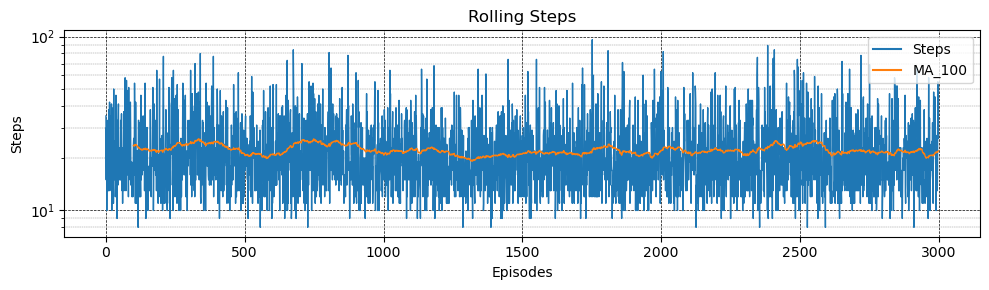

In [ ]:
# initiate CartPole environment
env = EnvCartPole(new_step_api=False)
agent3 = DQNAgent(env, n_episodes=3000, n_steps=1000, gamma=0.99, epsilon=1, # 100% random move
                  memory_cap=1000, batch_size=2, alpha=1.0e-4, tau=0.005, 
                  checkpoint_name="policy3", )
# Deep Q-Learning with experience replay
agent3.run(new_r=False)
# plot moving average for each episodes of training
agent3.rolling_plot()

## 4.3. Training a DQN Agent with a dynamic e-greedy policy and policy soft updates

[20/3000]: steps 21, epsilon 0.9185
[40/3000]: steps 11, epsilon 0.8905
[60/3000]: steps 11, epsilon 0.8621
[80/3000]: steps 18, epsilon 0.8294
[100/3000]: steps 17, epsilon 0.7881
[120/3000]: steps 67, epsilon 0.7286
[140/3000]: steps 41, epsilon 0.6789
[160/3000]: steps 39, epsilon 0.6219
[180/3000]: steps 500, epsilon 0.4804
[200/3000]: steps 223, epsilon 0.3288
INFO:tensorflow:Assets written to: policy4/policy_net/assets
INFO:tensorflow:Assets written to: policy4/target_net/assets
[220/3000]: steps 213, epsilon 0.2085
[240/3000]: steps 267, epsilon 0.1192
[260/3000]: steps 143, epsilon 0.0800
[280/3000]: steps 178, epsilon 0.0617
[300/3000]: steps 231, epsilon 0.0397
[320/3000]: steps 500, epsilon 0.0227
[340/3000]: steps 205, epsilon 0.0123
[360/3000]: steps 11, epsilon 0.0114
[380/3000]: steps 9, epsilon 0.0113
[400/3000]: steps 9, epsilon 0.0112
INFO:tensorflow:Assets written to: policy4/policy_net/assets
INFO:tensorflow:Assets written to: policy4/target_net/assets
[420/3000]: s

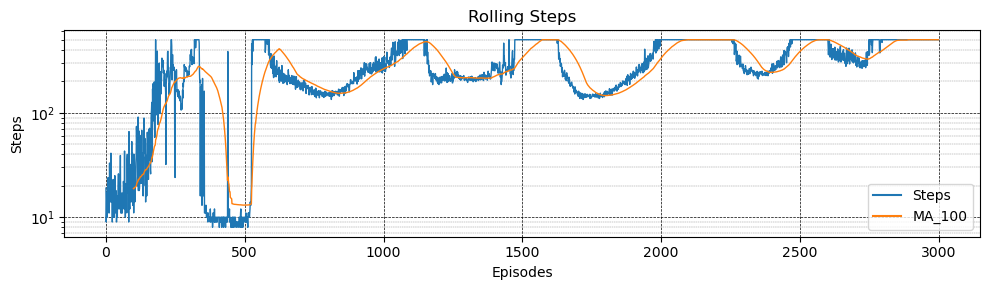

In [ ]:
# initiate CartPole environment
env = EnvCartPole(new_step_api=False)
agent4 = DQNAgent(env, n_episodes=3000, n_steps=1000, gamma=0.99, 
                  memory_cap=1000, batch_size=32, alpha=1.0e-4, tau=0.005,
                  epsilon=None, epsilon_start=0.95, epsilon_end=0.005, epsilon_decay=1.0e+04, 
                  checkpoint_name="policy4", )
# Deep Q-Learning with experience replay
agent4.run(new_r=False)
# plot moving average for each episodes of training
agent4.rolling_plot()

## 4.4. DQN Agent Comparison

Set epsilon to 0 to apply trained DQN Agent.

This training result has already reaches the TimeLimit of the environment.


read checkpoint from ./policy3.json
Epsilon starts from 0.0000
read checkpoint from ./policy4.json
Epsilon starts from 0.0050


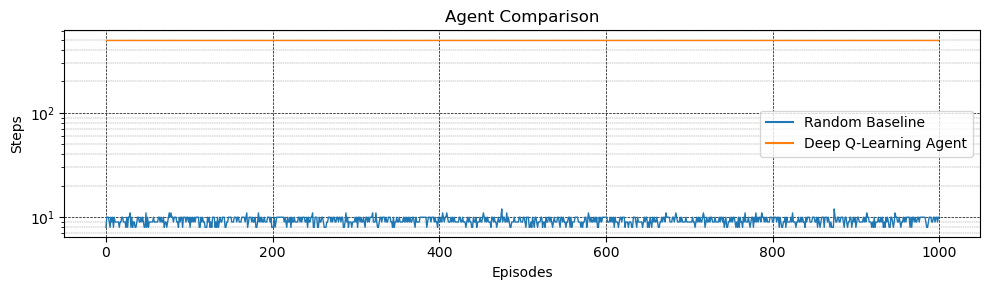

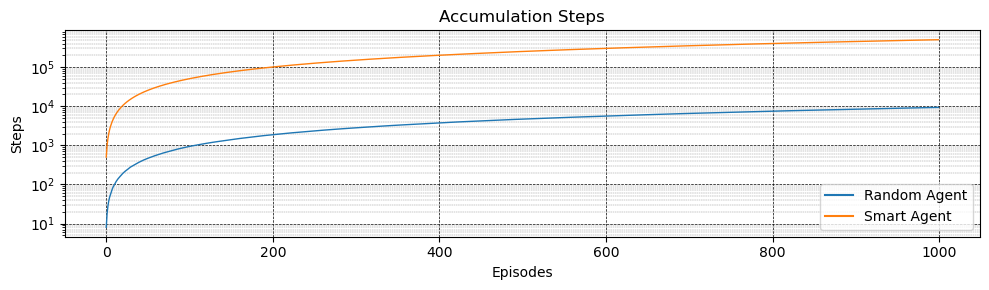

In [ ]:
# define e=0 to apply policy 3, which is a random baseline
agent3.epsilon=0
agent3.n_episodes=1000
test3 = agent3.test(new_r=False)

# define e=0 to apply policy 4, which is a well traind DQN Agent
agent4.epsilon=0
agent4.n_episodes=1000
test4 = agent4.test(new_r=False)

# plot and compare them
# 2 dimensional data structure
df = pd.DataFrame({"Random Baseline": test3[-1000:], "Deep Q-Learning Agent": test4[-1000:]})
# stack() --> Stack prescribed level (from columns to index)
# reset_index() --> Reset the index
df = df.stack().reset_index()
# set columns
df.columns = ["x", "hue", "y"]

# function vis
agent4.vis(df, "Agent Comparison", "Episodes", "Steps", "Agent comparison")
# function cumsum_plot
agent4.cumsum_plot(test3, test4)

In [ ]:
# Save the best agent
agent4.policy_net.save("policy4_500/policy_net/")
agent4.target_net.save("policy4_500/target_net/")

INFO:tensorflow:Assets written to: policy4_500/policy_net/assets
INFO:tensorflow:Assets written to: policy4_500/target_net/assets


#### 4.4.1. Reload the best weights and run the agent again with visualization

In [ ]:
# Rendering Dependencies
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
# Gym Dependencies
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1
!pip install gym[box2d] > /dev/null 2>&1

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# library import
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
# Google Colab needs to render the environment to a virtual display
from pyvirtualdisplay import Display

display = Display(visible=0, size=(1400, 900))
# we will record this as a video and play it after the training has finished
display.start()

# show_video
def show_video():
  # glob --> Unix style pathname (pattern expansion)
  mp4list = glob.glob('video/*.mp4')

  # check length mp4list larger than 0
  if len(mp4list) > 0:
    mp4 = mp4list[-1]
    video = io.open(mp4, 'r+b').read()
    # encoded
    encoded = base64.b64encode(video)
    # display
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

In [ ]:
# library import
from google.colab import drive

drive.mount('/content/drive/')
workspace = '/content/drive/My Drive/Colab Notebooks/AIDI 1008 - Reinforcement Learning/'
!ls "$workspace"  # "/content/drive/My Drive/Colab Notebooks/AIDI 1006 - Computer Vision/Assign 1"

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Assignment3_200520598_Fangji_Chen.ipynb     Fangji_Chen_Assign2.ipynb
Assignment3_200520598_Fangji_Chen_v2.ipynb  policy4_500
Fangji_Chen_Assign1.ipynb


In [ ]:
class Env:
    def __init__(self, new_step_api=True):
        self.name = 'CartPole-v1'
        # create gym environment
        self._env = gym.make(self.name)
        self.new_step_api = True
        pass

    def render(self, mode='rgb_array'):
        self._env.render(mode=mode)

    def step(self, action):
        # check for compatibility or not
        if self.new_step_api:
            # Updates the environment with the actions which returning in the observation of the next agent
            # with 4 value
            s_, r, terminated, truncated = self._env.step(action)[:4]
            
            # items() --> view object
            # larger than 1
            if len(truncated.items()) > 1:
                print('Unexpected [truncated] response.')

            # isinstance--> check if the specified object is in the specified type or not
            # check type = dict
            if isinstance(truncated, dict):
                try:
                    # value of item with specified key
                    # set truncated
                    truncated = truncated.get("TimeLimit.truncated")
                # Catching any exceptions that may occur during reading.
                except Exception as e:
                    # printing the error message
                    print('Failed to access key [TimeLimit.truncated], reset truncated as False. Error msg:')
                    print(str(e))
                    # set truncated
                    truncated = False
        else:
            # Updates the environment with the actions which returning in the observation of the next agent
            # with 3 value
            s_, r, terminated = self._env.step(action)[:3]
            # set truncated
            truncated = False

        # Create array
        s_ = np.array([s_])
        
        return s_, r, terminated, truncated

    def reset(self):
        # Reset the environment to the initial state
        s = self._env.reset()

        # isinstance--> check if the specified object is in the specified type or not
        # check s[1] = dict && s[0] = np.ndarray
        if isinstance(s[1], dict) and isinstance(s[0], np.ndarray):
            return np.array([s[0]])
        else:
            return np.array([s])
            
# Creating a Sequential model
# plain stack of layers with exactly one input tensor and one output tensor
dnn = Sequential([
    Input(shape=(4,)),
    # Dense layer
    Dense(128, activation=relu),
    Dense(128, activation=relu),
    Dense(2, activation=linear)
])

# Model training
# Loss function = mse
# Optimizer instance = Adam(learning_rate=1.0e-4)
dnn.compile(loss=mse, optimizer=Adam(learning_rate=1.0e-4))
dnn._name = "agent_best_ever"
# load target_net
dnn.load_weights(workspace + "/policy4_500/target_net/")

# library import
from gym.wrappers.monitoring.video_recorder import VideoRecorder

# set environment with Env class (new_step_api = True)
env = Env(new_step_api=True)
rec = VideoRecorder(env._env, path="./video/vid.mp4")

# range 10
for episode in range(10):
    # Reset the environment to the initial state
    s = env.reset()
    
    # count() --> the number of elements
    for step in count():
        # Updates the environment with the actions which returning in the observation of the next agent
        # with 4 value
        s, _, done, trunc = env.step(np.argmax(dnn(s)))
        rec.capture_frame()

        # check done/trunc
        if done or trunc:
            print("[%d/%d]: steps %d" % (episode + 1, 10, step + 1))
            break
        
rec.close()
show_video()


/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment CartPole-v1 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wr

[1/10]: steps 500
[2/10]: steps 500
[3/10]: steps 500
[4/10]: steps 500
[5/10]: steps 500
[6/10]: steps 500
[7/10]: steps 500
[8/10]: steps 500
[9/10]: steps 500
[10/10]: steps 500


# 5. Keras-RL Library Implementation

Author:
* Cheuk Ying Iu(200514612) 
* Harini Anand(200525035)

In [ ]:
!pip install keras-rl2 > /dev/null 2>&1

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# library import
from rl.agents.dqn import DQNAgent as KerasDQN
from rl.policy import BoltzmannQPolicy, Policy, GreedyQPolicy
from rl.memory import SequentialMemory
from rl.agents.dqn import DQNAgent as KerasDQN

In [ ]:
def get_model():
    # Creating a Sequential model
    # plain stack of layers with exactly one input tensor and one output tensor
    keras_dqn = Sequential()
    
    # Dense layer
    keras_dqn.add(Dense(20, activation='relu', input_shape=(1, 4)))
    keras_dqn.add(Dense(20, activation='relu'))
    keras_dqn.add(Dense(2, activation='linear'))
    keras_dqn.add(Flatten())

    print(keras_dqn.summary())

    return keras_dqn

/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
def run_keras_rl_dqn(policy, train_steps=3000, test_steps=200):
    # create gym environment
    env = gym.make('CartPole-v1')
    # store various states in DQN
    memory = SequentialMemory(limit=50000, window_length=1)
    dqn = KerasDQN(model=get_model(), nb_actions=2, memory=memory, nb_steps_warmup=10, target_model_update=1e-2, policy=policy)
    # Model training
    # Loss function = mse
    # Optimizer instance = Adam(lr=1e-3)
    dqn.compile(Adam(lr=1e-3), metrics=['mse'])
    # trains
    trains = dqn.fit(env, nb_steps=train_steps, visualize=False, verbose=2)
    # tests
    tests = dqn.test(env, nb_episodes=test_steps, visualize=False)
    # dqn.save_weights('dqn_{}_weights.h5f'.format("CartPole-v1"), overwrite=True)
    return trains, tests

## 5.1. Train a Keras-RL DQN Agent with a Random Policy

In [ ]:
class RandomQPolicy(Policy):
    """Implement the random policy
    Random policy returns a random action
    """
    def select_action(self, q_values):
        # debugging
        assert q_values.ndim == 1

        # np.random.randint() --> integer number which selected element from specified range
        action = np.random.randint(0, 1)

        return action

# class RandomQPolicy
policy_random = RandomQPolicy()

trains1, tests1 = run_keras_rl_dqn(policy_random, train_steps=3000, test_steps=1000)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 1, 20)             100       
                                                                 
 dense_34 (Dense)            (None, 1, 20)             420       
                                                                 
 dense_35 (Dense)            (None, 1, 2)              42        
                                                                 
 flatten_6 (Flatten)         (None, 2)                 0         
                                                                 
Total params: 562
Trainable params: 562
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


None
Training for 3000 steps ...


/usr/local/lib/python3.9/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


   10/3000: episode: 1, duration: 0.525s, episode steps:  10, steps per second:  19, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: --, mse: --, mean_q: --


/usr/local/lib/python3.9/dist-packages/rl/memory.py:37: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')
/usr/local/lib/python3.9/dist-packages/rl/memory.py:38: DeprecationWarning: This function is deprecated. Please call randint(1, 11 + 1) instead
  batch_idxs = np.random.random_integers(low, high - 1, size=size)
/usr/local/lib/python3.9/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/usr/local/lib/python3.9/dist-packages/rl/memory.py:38: DeprecationWarning: This function is deprecated. Please call randint(1, 12 + 1) instead
  batch_idxs = np.random.random_integers(low, high - 1, size=size)

   20/3000: episode: 2, duration: 2.827s, episode steps:  10, steps per second:   4, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.435935, mse: 0.492456, mean_q: 0.157425
   28/3000: episode: 3, duration: 0.174s, episode steps:   8, steps per second:  46, episode reward:  8.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.283914, mse: 0.352396, mean_q: 0.380368


/usr/local/lib/python3.9/dist-packages/rl/memory.py:38: DeprecationWarning: This function is deprecated. Please call randint(1, 23 + 1) instead
  batch_idxs = np.random.random_integers(low, high - 1, size=size)
/usr/local/lib/python3.9/dist-packages/rl/memory.py:38: DeprecationWarning: This function is deprecated. Please call randint(1, 24 + 1) instead
  batch_idxs = np.random.random_integers(low, high - 1, size=size)
/usr/local/lib/python3.9/dist-packages/rl/memory.py:38: DeprecationWarning: This function is deprecated. Please call randint(1, 25 + 1) instead
  batch_idxs = np.random.random_integers(low, high - 1, size=size)
/usr/local/lib/python3.9/dist-packages/rl/memory.py:38: DeprecationWarning: This function is deprecated. Please call randint(1, 26 + 1) instead
  batch_idxs = np.random.random_integers(low, high - 1, size=size)
/usr/local/lib/python3.9/dist-packages/rl/memory.py:38: DeprecationWarning: This function is deprecated. Please call randint(1, 27 + 1) instead
  batch_idxs

   37/3000: episode: 4, duration: 0.192s, episode steps:   9, steps per second:  47, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.204223, mse: 0.256094, mean_q: 0.548702
   47/3000: episode: 5, duration: 0.209s, episode steps:  10, steps per second:  48, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.153666, mse: 0.201499, mean_q: 0.747105
   57/3000: episode: 6, duration: 0.212s, episode steps:  10, steps per second:  47, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.143268, mse: 0.191168, mean_q: 0.918217
   67/3000: episode: 7, duration: 0.220s, episode steps:  10, steps per second:  45, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.128330, mse: 0.175282, mean_q: 1.053738
   77/3000: episode: 8, duration: 0.223s, episode steps:  10, steps per seco

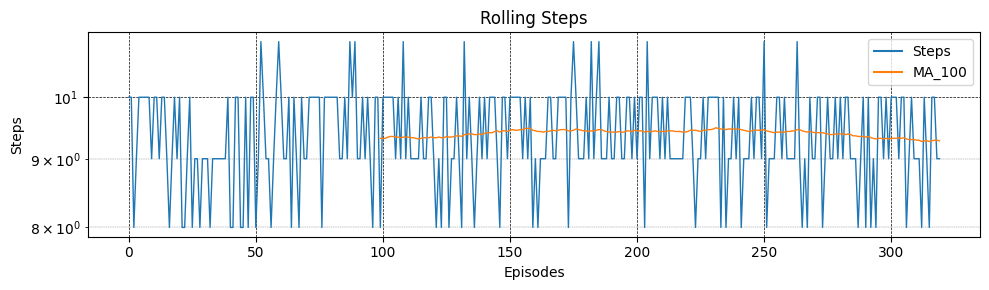

In [ ]:
# class Agent
worker = Agent(EnvCartPole())
worker.steps = trains1.history.get("nb_episode_steps")
# function rolling_plot
worker.rolling_plot()

## 5.2. Train a Keras-RL DQN Agent with BoltzmannQ Policy

In [ ]:
# BoltzmannQPolicy
policy_greedy = BoltzmannQPolicy()

trains2, tests2 = run_keras_rl_dqn(policy_greedy, train_steps=3000, test_steps=1000)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 1, 20)             100       
                                                                 
 dense_37 (Dense)            (None, 1, 20)             420       
                                                                 
 dense_38 (Dense)            (None, 1, 2)              42        
                                                                 
 flatten_7 (Flatten)         (None, 2)                 0         
                                                                 
Total params: 562
Trainable params: 562
Non-trainable params: 0
_________________________________________________________________
None


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/keras/o

Training for 3000 steps ...


/usr/local/lib/python3.9/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/usr/local/lib/python3.9/dist-packages/rl/memory.py:37: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')
/usr/local/lib/python3.9/dist-packages/rl/memory.py:38: DeprecationWarning: This function is deprecated. Please call randint(1, 10 + 1) instead
  batch_idxs = np.random.random_integers(low, high - 1, size=size)
/usr/local/lib/python3.9/dist-packages/rl/memory.py:38: DeprecationWarning: This function is deprecated. Please call randint(1, 11 + 1) instead
  batch_idxs = np.random.random_integers(low, high - 1, size=size)

   29/3000: episode: 1, duration: 1.987s, episode steps:  29, steps per second:  15, episode reward: 29.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.483 [0.000, 1.000],  loss: 0.475615, mse: 0.477298, mean_q: 0.054596
   45/3000: episode: 2, duration: 0.186s, episode steps:  16, steps per second:  86, episode reward: 16.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.625 [0.000, 1.000],  loss: 0.396361, mse: 0.408232, mean_q: 0.169219


/usr/local/lib/python3.9/dist-packages/rl/memory.py:37: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')
/usr/local/lib/python3.9/dist-packages/rl/memory.py:38: DeprecationWarning: This function is deprecated. Please call randint(1, 29 + 1) instead
  batch_idxs = np.random.random_integers(low, high - 1, size=size)
/usr/local/lib/python3.9/dist-packages/rl/memory.py:38: DeprecationWarning: This function is deprecated. Please call randint(1, 30 + 1) instead
  batch_idxs = np.random.random_integers(low, high - 1, size=size)
/usr/local/lib/python3.9/dist-packages/rl/memory.py:38: DeprecationWarning: This function is deprecated. Please call randint(1, 31 + 1) instead
  batch_idxs = np.random.random_integers(low, high - 1, size=size)


   58/3000: episode: 3, duration: 0.150s, episode steps:  13, steps per second:  87, episode reward: 13.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.308 [0.000, 1.000],  loss: 0.320282, mse: 0.368517, mean_q: 0.321409
   66/3000: episode: 4, duration: 0.100s, episode steps:   8, steps per second:  80, episode reward:  8.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.125 [0.000, 1.000],  loss: 0.246990, mse: 0.335859, mean_q: 0.444219
   84/3000: episode: 5, duration: 0.226s, episode steps:  18, steps per second:  80, episode reward: 18.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.333 [0.000, 1.000],  loss: 0.166030, mse: 0.355243, mean_q: 0.646698
  103/3000: episode: 6, duration: 0.241s, episode steps:  19, steps per second:  79, episode reward: 19.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.368 [0.000, 1.000],  loss: 0.090957, mse: 0.509771, mean_q: 0.939493
  118/3000: episode: 7, duration: 0.187s, episode steps:  15, steps per seco

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


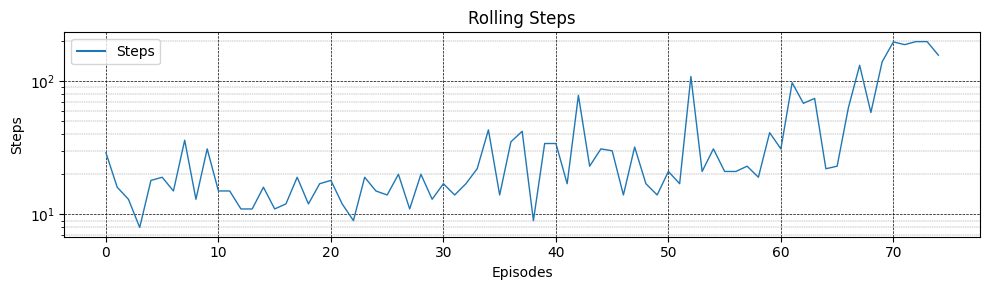

In [ ]:
# class Agent
worker = Agent(EnvCartPole())
worker.steps = trains2.history.get("nb_episode_steps")
# function rolling_plot
worker.rolling_plot()

## 5.3. Agent performance comparison

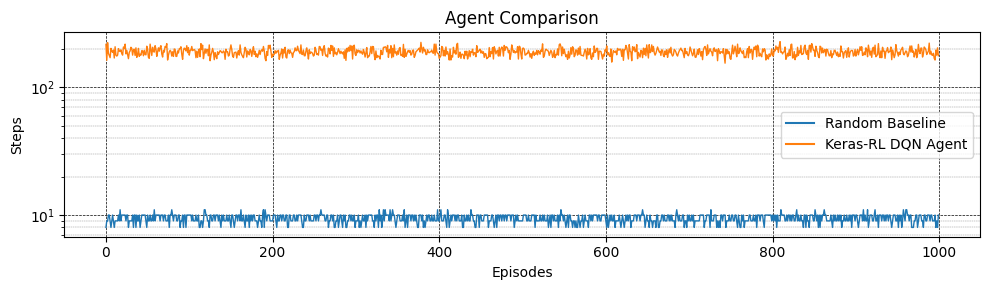

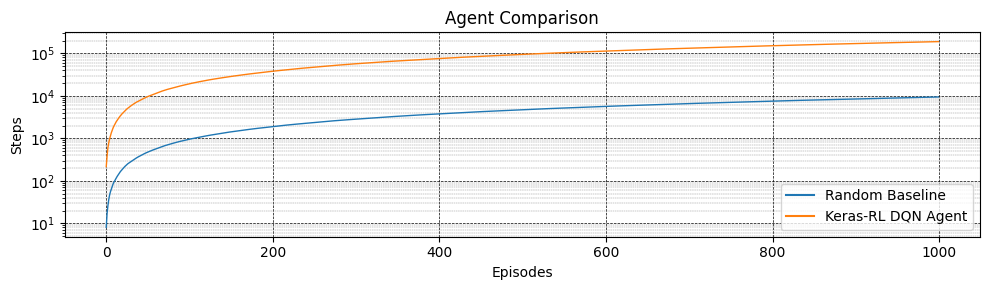

In [ ]:
worker = Agent(EnvCartPole())
worker.steps = tests2.history.get("nb_steps")

# 2 dimensional data structure
df = pd.DataFrame({"Random Baseline": tests1.history.get("nb_steps"), 
                   "Keras-RL DQN Agent": tests2.history.get("nb_steps")})
# function dataframe_stack
df = worker.dataframe_stack(df)
# function vis
worker.vis(df, "Agent Comparison", "Episodes", "Steps", "Agent comparison")

# 2 dimensional data structure
df = pd.DataFrame({"Random Baseline": np.cumsum(tests1.history.get("nb_steps")), 
                   "Keras-RL DQN Agent": np.cumsum(tests2.history.get("nb_steps"))
                   })
# function dataframe_stack
df = worker.dataframe_stack(df)
# function vis
worker.vis(df, "Agent Comparison", "Episodes", "Steps", "Agent comparison")

# 6. explore potential better new defination of environment rewards 

Author:
* Fangji Chen(200520598)

Only gives a punishment reward -1 when meeting a terminate state, otherwise 0.

## 6.1. New rewards for training a new Q-Learning Agent

The training results of the Q-Learning Agent improves much faster then the original reward policy.

[50/3000]: 62, 1.0000
[100/3000]: 36, 1.0000
[150/3000]: 33, 1.0000
[200/3000]: 19, 1.0000
[250/3000]: 16, 1.0000
[300/3000]: 39, 1.0000
[350/3000]: 36, 1.0000
[400/3000]: 17, 1.0000
[450/3000]: 29, 1.0000
[500/3000]: 12, 1.0000
[550/3000]: 22, 1.0000
[600/3000]: 11, 1.0000
[650/3000]: 19, 1.0000
[700/3000]: 21, 1.0000
[750/3000]: 9, 1.0000
[800/3000]: 25, 1.0000
[850/3000]: 15, 1.0000
[900/3000]: 12, 1.0000
[950/3000]: 23, 1.0000
[1000/3000]: 17, 1.0000
[1050/3000]: 19, 1.0000
[1100/3000]: 23, 1.0000
[1150/3000]: 38, 1.0000
[1200/3000]: 19, 1.0000
[1250/3000]: 19, 1.0000
[1300/3000]: 12, 1.0000
[1350/3000]: 10, 1.0000
[1400/3000]: 15, 1.0000
[1450/3000]: 17, 1.0000
[1500/3000]: 16, 1.0000
[1550/3000]: 15, 1.0000
[1600/3000]: 21, 1.0000
[1650/3000]: 30, 1.0000
[1700/3000]: 13, 1.0000
[1750/3000]: 12, 1.0000
[1800/3000]: 22, 1.0000
[1850/3000]: 18, 1.0000
[1900/3000]: 15, 1.0000
[1950/3000]: 49, 1.0000
[2000/3000]: 11, 1.0000
[2050/3000]: 19, 1.0000
[2100/3000]: 11, 1.0000
[2150/3000]: 

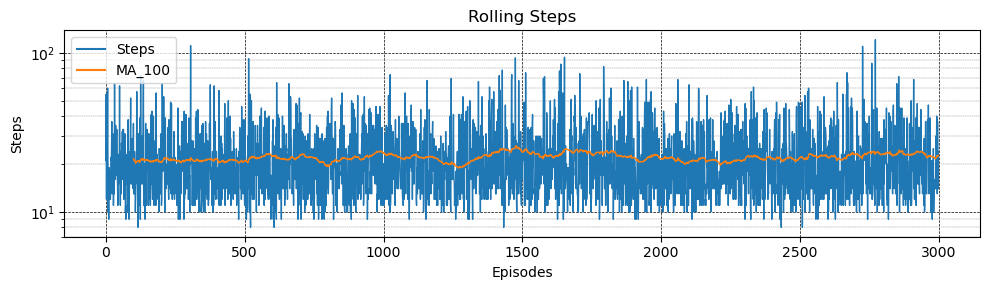

In [ ]:
# initiate CartPole environment with 8^4 discrete state spaces
env = EnvCartPole(discrete_base=8, new_step_api=False)
agent1 = QAgent(env, n_episodes=3000, n_steps=1000, gamma=0.99, alpha=0.5, epsilon=1, # 100% random move
                checkpoint_name="policy1", )
# The Q-Learning (off-policy TD control) for estimating π≈π*
agent1.run(new_r=True)  # ------------------------------------------------------ train with new rewards
# plot moving average for each episodes of training
agent1.rolling_plot()

[50/3000]: 17, 0.0986
[100/3000]: 69, 0.0950
[150/3000]: 75, 0.0889
[200/3000]: 129, 0.0820
[250/3000]: 21, 0.0748
[300/3000]: 117, 0.0673
[350/3000]: 143, 0.0604
[400/3000]: 164, 0.0539
[450/3000]: 75, 0.0479
[500/3000]: 98, 0.0441
[550/3000]: 325, 0.0387
[600/3000]: 359, 0.0319
[650/3000]: 283, 0.0268
[700/3000]: 238, 0.0222
[750/3000]: 113, 0.0200
[800/3000]: 125, 0.0188
[850/3000]: 133, 0.0177
[900/3000]: 167, 0.0167
[950/3000]: 178, 0.0157
[1000/3000]: 168, 0.0148
[1050/3000]: 188, 0.0139
[1100/3000]: 291, 0.0131
[1150/3000]: 291, 0.0124
[1200/3000]: 249, 0.0119
[1250/3000]: 190, 0.0114
[1300/3000]: 147, 0.0112
[1350/3000]: 149, 0.0110
[1400/3000]: 142, 0.0109
[1450/3000]: 149, 0.0108
[1500/3000]: 121, 0.0107
[1550/3000]: 72, 0.0106
[1600/3000]: 129, 0.0105
[1650/3000]: 10, 0.0105
[1700/3000]: 120, 0.0105
[1750/3000]: 123, 0.0104
[1800/3000]: 291, 0.0103
[1850/3000]: 86, 0.0103
[1900/3000]: 219, 0.0102
[1950/3000]: 250, 0.0102
[2000/3000]: 244, 0.0101
[2050/3000]: 207, 0.0101
[210

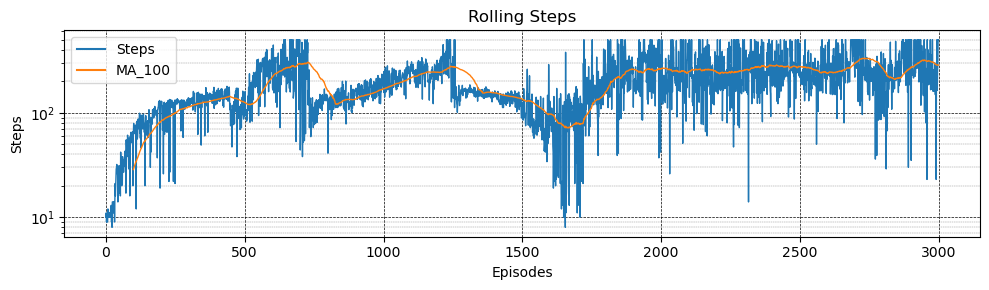

In [ ]:
# initiate CartPole environment with 10^4 discrete state spaces
env = EnvCartPole(discrete_base=10, new_step_api=False)
agent2 = QAgent(env, n_episodes=3000, n_steps=1000, gamma=0.99, alpha=0.3, epsilon=None,
                epsilon_start=0.1, epsilon_end=0.01, epsilon_decay=5.0e+04, 
                checkpoint_name="policy2", )
# The Q-Learning (off-policy TD control) for estimating π≈π*
agent2.run(new_r=True)  # ------------------------------------------------------ train with new rewards
# plot moving average for each episodes of training
agent2.rolling_plot()

read checkpoint from ./policy1.json
Epsilon starts from 0.0000
read checkpoint from ./policy2.json
Epsilon starts from 0.0000


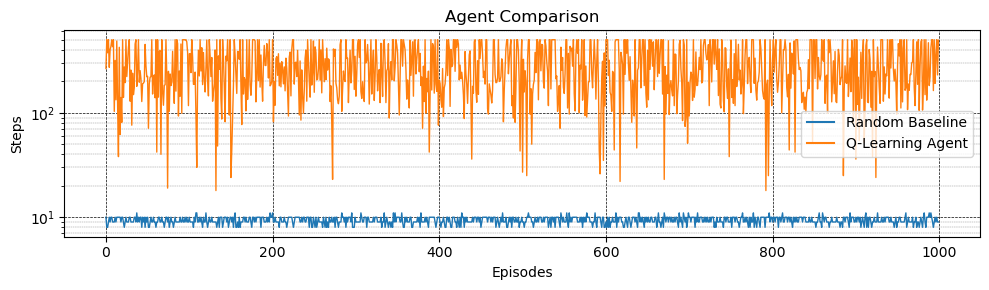

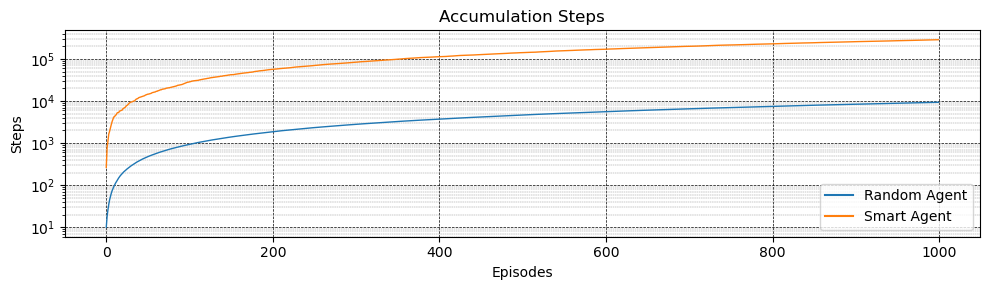

In [ ]:
# define e=0 to apply policy 1, which is a random baseline
agent1 = QAgent(env, n_episodes=1000, epsilon=0, checkpoint_name="policy1", )
test1 = agent1.test(new_r=True)

# define e=0 to apply policy 2, which is a Q-Learning Agent
agent2 = QAgent(env, n_episodes=1000, epsilon=0, checkpoint_name="policy2", )
test2 = agent2.test(new_r=True)

df = pd.DataFrame({"Random Baseline": test1[-1000:], "Q-Learning Agent": test2[-1000:]})
# stack() --> Stack prescribed level (from columns to index)
# reset_index() --> Reset the index
df = df.stack().reset_index()
df.columns = ["x", "hue", "y"]

agent2.vis(df, "Agent Comparison", "Episodes", "Steps", "Agent comparison") # plot Agent Comparison line plot
agent2.cumsum_plot(test1, test2) # plot Agent Comparison line plot with step accumulative sum


## 6.2. New rewards for training a new DQN Agent

The training results of the DQN Agent improves much faster then the original reward policy.

[20/3000]: steps 38, epsilon 1.0000
[40/3000]: steps 34, epsilon 1.0000
[60/3000]: steps 14, epsilon 1.0000
[80/3000]: steps 16, epsilon 1.0000
[100/3000]: steps 30, epsilon 1.0000
[120/3000]: steps 16, epsilon 1.0000
[140/3000]: steps 27, epsilon 1.0000
[160/3000]: steps 19, epsilon 1.0000
[180/3000]: steps 22, epsilon 1.0000
[200/3000]: steps 13, epsilon 1.0000
INFO:tensorflow:Assets written to: policy3/policy_net/assets
INFO:tensorflow:Assets written to: policy3/target_net/assets
[220/3000]: steps 15, epsilon 1.0000
[240/3000]: steps 13, epsilon 1.0000
[260/3000]: steps 10, epsilon 1.0000
[280/3000]: steps 23, epsilon 1.0000
[300/3000]: steps 15, epsilon 1.0000
[320/3000]: steps 15, epsilon 1.0000
[340/3000]: steps 9, epsilon 1.0000
[360/3000]: steps 10, epsilon 1.0000
[380/3000]: steps 12, epsilon 1.0000
[400/3000]: steps 18, epsilon 1.0000
INFO:tensorflow:Assets written to: policy3/policy_net/assets
INFO:tensorflow:Assets written to: policy3/target_net/assets
[420/3000]: steps 41,

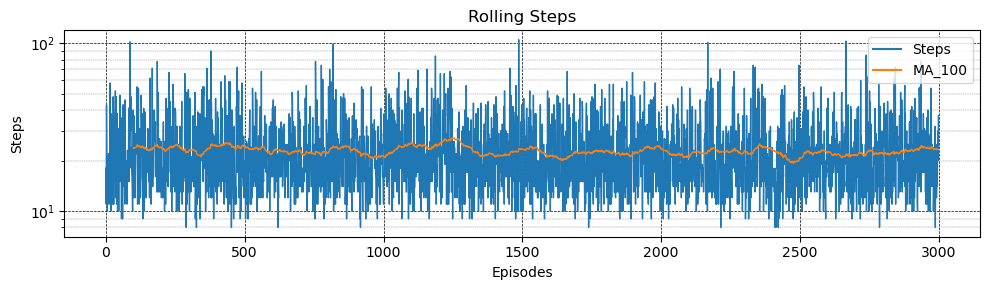

In [ ]:
# initiate CartPole environment
env = EnvCartPole(new_step_api=False)
agent3 = DQNAgent(env, n_episodes=3000, n_steps=1000, gamma=0.99, epsilon=1, # 100% random move
                  memory_cap=1000, batch_size=2, alpha=1.0e-4, tau=0.005, 
                  checkpoint_name="policy3", )
# Deep Q-Learning with experience replay
agent3.run(new_r=True)  # ------------------------------------------------------ train with new reward
# plot moving average for each episodes of training
agent3.rolling_plot()

[20/3000]: steps 15, epsilon 0.0975
[40/3000]: steps 23, epsilon 0.0933
[60/3000]: steps 366, epsilon 0.0662
[80/3000]: steps 398, epsilon 0.0409
[100/3000]: steps 152, epsilon 0.0289
[120/3000]: steps 143, epsilon 0.0228
[140/3000]: steps 122, epsilon 0.0185
[160/3000]: steps 162, epsilon 0.0152
[180/3000]: steps 226, epsilon 0.0119
[200/3000]: steps 322, epsilon 0.0087
INFO:tensorflow:Assets written to: policy4/policy_net/assets
INFO:tensorflow:Assets written to: policy4/target_net/assets
[220/3000]: steps 500, epsilon 0.0065
[240/3000]: steps 500, epsilon 0.0056
[260/3000]: steps 321, epsilon 0.0053
[280/3000]: steps 359, epsilon 0.0052
[300/3000]: steps 500, epsilon 0.0051
[320/3000]: steps 500, epsilon 0.0050
[340/3000]: steps 500, epsilon 0.0050
[360/3000]: steps 500, epsilon 0.0050
[380/3000]: steps 500, epsilon 0.0050
[400/3000]: steps 500, epsilon 0.0050
INFO:tensorflow:Assets written to: policy4/policy_net/assets
INFO:tensorflow:Assets written to: policy4/target_net/assets
[4

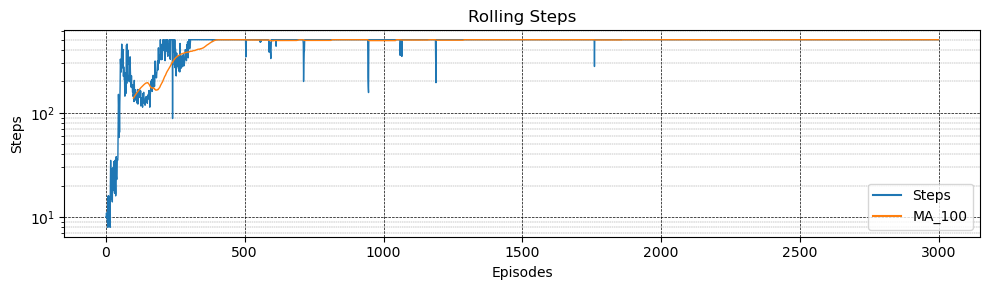

In [ ]:
# initiate CartPole environment
env = EnvCartPole(new_step_api=False)
agent4 = DQNAgent(env, n_episodes=3000, n_steps=1000, gamma=0.99, 
                  memory_cap=1000, batch_size=32, alpha=1.0e-4, tau=0.005,
                  epsilon=None, epsilon_start=0.1, epsilon_end=0.005, epsilon_decay=1.0e+04, 
                  checkpoint_name="policy4", )
# Deep Q-Learning with experience replay
agent4.run(new_r=True)  # ------------------------------------------------------ train with new reward
# plot moving average for each episodes of training
agent4.rolling_plot()

read checkpoint from ./policy3.json
Epsilon starts from 0.0000
read checkpoint from ./policy4.json
Epsilon starts from 0.0050


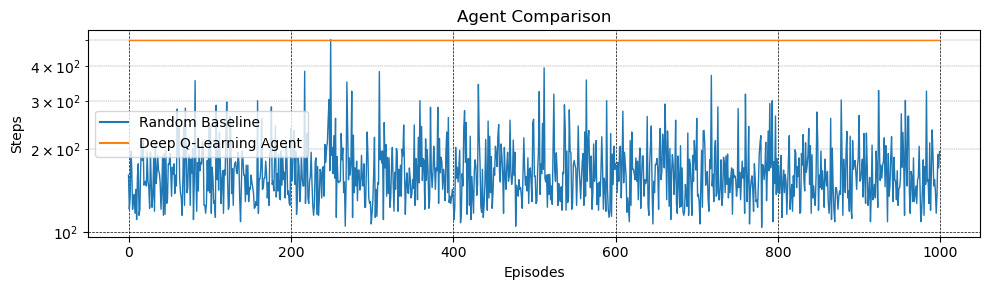

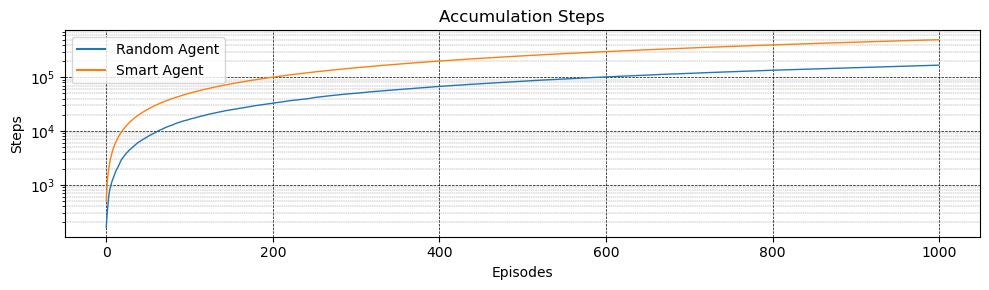

In [ ]:
# define e=0 to apply policy 3, which is a random baseline
agent3.epsilon=0
agent3.n_episodes=1000
test3 = agent3.test(new_r=True)

# define e=0 to apply policy 4, which is a well traind DQN Agent
agent4.epsilon=0
agent4.n_episodes=1000
test4 = agent4.test(new_r=True)

# plot and compare them
# 2 dimensional data structure
df = pd.DataFrame({"Random Baseline": test3[-1000:], "Deep Q-Learning Agent": test4[-1000:]})
# stack() --> Stack prescribed level (from columns to index)
# reset_index() --> Reset the index
df = df.stack().reset_index()
# set columns
df.columns = ["x", "hue", "y"]

# function vis
agent4.vis(df, "Agent Comparison", "Episodes", "Steps", "Agent comparison")
# function cumsum_plot
agent4.cumsum_plot(test3, test4)

## 6.3. Conclusion for section 6

Design a proper reward system is a critical matter for training a successful RL agent

# 7. Applying Q-Learning and DQN on Forzen-Lake-V1

Author:
* Fangji Chen(200520598)

## 7.1. Environment

In [7]:
class EnvFrozenLake:
    def __init__(self, state_def):
        self._form=["scalar", "tensor"]
        assert(state_def in self._form)
        self.state_def = state_def
        self._env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False)
        self.n_actions = self._env.action_space.n
        self.n_observation_space = 1
        pass

    def sample_action(self):
        return self._env.action_space.sample()

    def reset(self):
        s = self._env.reset()
        if isinstance(s, tuple):
            s = s[0]
        if self.state_def == "scalar":
            return s
        else:
            z = np.zeros(16)
            z[s] = 1
            return np.array([z])

    def step(self, a, new_reward=False):
        s_, r, terminated = self._env.step(a)[:3]
        if self.state_def == "tensor":
            z = np.zeros(16)
            z[s_] = 1
            s_ = np.array([z])
        else:
            s_ = s_
        if terminated:
            if r == 0.0:
                r = 0.
            elif r == 1.0:
                r = 1.
                print("success")
        return s_, r, terminated, False


In [13]:
def plot(ag):
    for i in range(16):
        if ag.Q.get(str(i)) is None:
            ag.Q.setdefault(i, [0.0] * ag.n_actions)
    df_ = pd.DataFrame(ag.Q).T.sort_index()
    df_[df_==0]=np.NaN
    # df_ = (df_[df_ > 0] + 1).apply(lambda x: np.log(x))
    mini = df_.min().min()
    maxi = df_.max().max()
    df_ = (df_ - mini + 0.01) / (maxi - mini + 0.01) / 2.2
    df_[df_ < 0] = 0.00001
    df_[np.isnan(df_)]=0.0
    df_.index = df_.index.astype(int)

    plt.subplots(figsize=(5, 5))
    max_q = df_.max(axis=1)
    arr = max_q.sort_index().values.reshape(-1, 4)
    plt.imshow(arr, extent=[0, 4, 0, 4], cmap='gray', vmin=0, vmax=1)
    for i in range(16):  # 16 grids
        x = i % 4 + 0.5
        y = 4 - i // 4 - 0.5
        arr = df_.loc[i].values
        indices = arr.argsort()
        max_ = arr.max()
        min_ = arr.min()
        for j in range(4):  # 4 act
            if min_ == max_:
                continue
            w, h = 0, 0
            if j == 0:
                w, h = arr[j] * -1, 0
            elif j == 1:
                w, h = 0, arr[j] * -1
            elif j == 2:
                w, h = arr[j] * 1, 0
            elif j == 3:
                w, h = 0, arr[j] * 1
            width = (np.argwhere(indices == j).flatten()[0] + 1) / 100
            width = (max(indices) + 1) / 100 if arr[j] == max_ else width
            fc = 'darksalmon' if arr[j] == max_ else 'black'
            ec = 'red' if j == np.argmax(arr) else fc
            plt.arrow(x, y, w, h, width=width, ec=ec, fc=fc)
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()
    plt.show()
    return df_ # Q-Table:

In [9]:
def test(ag):
    ag.env._env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False)  #, render_mode="human")  #
    for episode in range(10):
        print("Testing episode: ", episode, "/10", end=" ")
        s = ag.env.reset()
        for step in range(20):
            a = ag.action(s)
            if isinstance(s, int):
                print("(s,a)=(%d,%d)" % (s,a), end=" ")
            else:
                print("(s,a)=(%d,%d)" % (np.argmax(s),a), end=" ")
            s, r, done, trunc = ag.env.step(a, new_reward=False)
            if done:
                break
        print()

In [10]:
def train(ag):
    for episode in range(1, ag.n_episodes + 1):
        s = ag.env.reset()
        for step in range(1, ag.n_steps + 1):
            a = ag.action(s)
            s_, r, done, trunc = ag.env.step(a, new_reward=False)
            ag.learning(s, a, r, s_, done)
            s = s_
            if done:
                ag.steps.append(step)
                if r == 1:
                    print("got a reward")
                    return
                break
        if episode % 10 == 0:
            print("[%d/%d]: %d, %.4f" % (episode, ag.n_episodes, step, ag.epsilon))

## 7.2. DQN on FrozenLake

In [18]:
# Training DQN Agent for 50 episodes and success once
env = EnvFrozenLake(state_def="tensor")
env.n_observation_space = 16
agent5 = DQNAgent(env, n_episodes=10, n_steps=50, gamma=0.85,
                  memory_cap=1000, batch_size=128, alpha=1.0e-2, tau=0.05,
                  epsilon=None, epsilon_start=0.9, epsilon_end=0.01, epsilon_decay=3.0e+03,
                  checkpoint_name="policy4", )

### 7.2.1. No success rewards got

[10/10]: steps 3, epsilon 0.8835


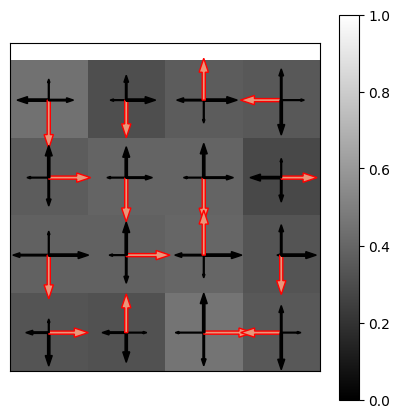

In [19]:
agent5.n_episodes = 10
agent5.dynamic_e_greedy = True
agent5.run(new_r=False, debugging_freq=10)
q_a = defaultdict(lambda: np.zeros(16))
for i in range(16):
    zs = np.zeros(16)
    zs[i] = 1
    q_a[i] = agent5.policy_net(np.array([zs])).numpy().flatten().tolist()
agent5.Q = q_a
_ = plot(agent5)

### 7.2.2. Keep finding

[10/1000]: 2, 0.8746
[20/1000]: 23, 0.8387
[30/1000]: 25, 0.8118
[40/1000]: 4, 0.7967
success
got a reward


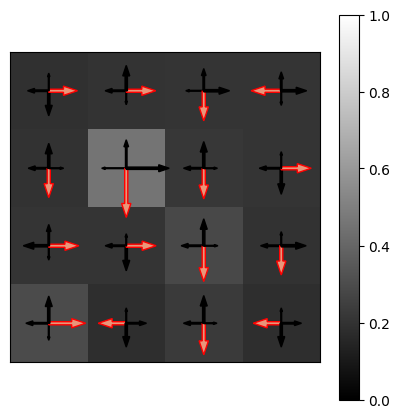

In [20]:
# Find a reward
agent5.n_episodes=1000
agent5.dynamic_e_greedy = True
train(agent5)
q_a = defaultdict(lambda: np.zeros(16))
for i in range(16):
    zs = np.zeros(16)
    zs[i] = 1
    q_a[i] = agent5.policy_net(np.array([zs])).numpy().flatten().tolist()
agent5.Q = q_a
_ = plot(agent5)

success
got a reward


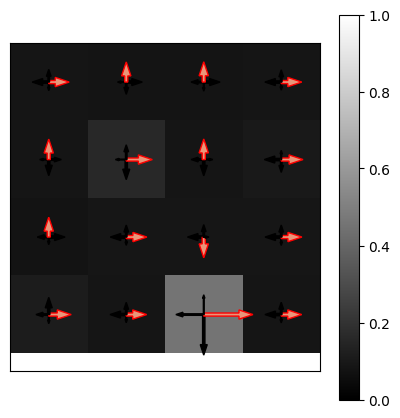

In [21]:
# Keep finding
agent5.n_episodes=1000
agent5.dynamic_e_greedy = True
train(agent5)
q_a = defaultdict(lambda: np.zeros(16))
for i in range(16):
    zs = np.zeros(16)
    zs[i] = 1
    q_a[i] = agent5.policy_net(np.array([zs])).numpy().flatten().tolist()
agent5.Q = q_a
_ = plot(agent5)

success
got a reward


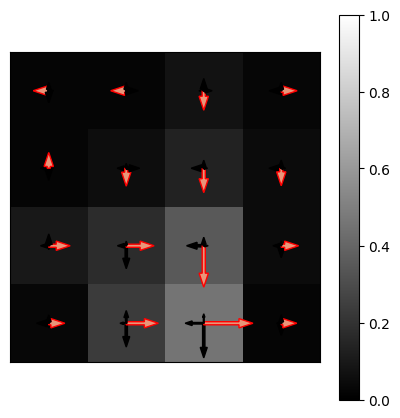

In [22]:
# Keep finding
agent5.n_episodes=1000
agent5.dynamic_e_greedy = True
train(agent5)
q_a = defaultdict(lambda: np.zeros(16))
for i in range(16):
    zs = np.zeros(16)
    zs[i] = 1
    q_a[i] = agent5.policy_net(np.array([zs])).numpy().flatten().tolist()
agent5.Q = q_a
_ = plot(agent5)

### 7.2.3. Optimized policy reached

success
got a reward


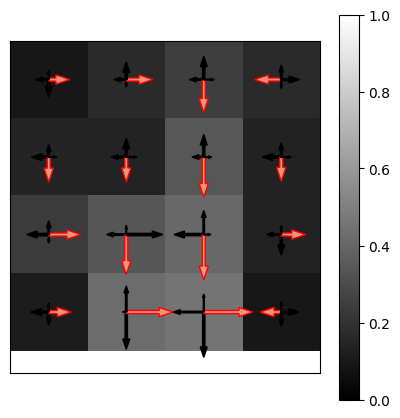

In [23]:
# Keep finding
agent5.n_episodes=1000
agent5.dynamic_e_greedy = True
train(agent5)
q_a = defaultdict(lambda: np.zeros(16))
for i in range(16):
    zs = np.zeros(16)
    zs[i] = 1
    q_a[i] = agent5.policy_net(np.array([zs])).numpy().flatten().tolist()
agent5.Q = q_a
_ = plot(agent5)

### 7.2.4. Visualizing training convergency after reaching optimal solution

success
success
success
success
[10/500]: steps 3, epsilon 0.7160
success
success
[20/500]: steps 9, epsilon 0.7006
success
success
[30/500]: steps 14, epsilon 0.6862
success
[40/500]: steps 2, epsilon 0.6704
success
success
success
[50/500]: steps 7, epsilon 0.6552
success
success
[60/500]: steps 13, epsilon 0.6363
success
success
success
[70/500]: steps 8, epsilon 0.6217
success
success
[80/500]: steps 4, epsilon 0.6092
success
success
[90/500]: steps 5, epsilon 0.5981
success
success
[100/500]: steps 4, epsilon 0.5864
success
[110/500]: steps 6, epsilon 0.5760
[120/500]: steps 9, epsilon 0.5685
success
[130/500]: steps 9, epsilon 0.5560
success
success
success
success
[140/500]: steps 7, epsilon 0.5466
success
success
success
[150/500]: steps 5, epsilon 0.5340
success
success
success
success
success
[160/500]: steps 9, epsilon 0.5214
success
success
[170/500]: steps 4, epsilon 0.5088
success
success
success
success
success
[180/500]: steps 11, epsilon 0.4981
success
success
success


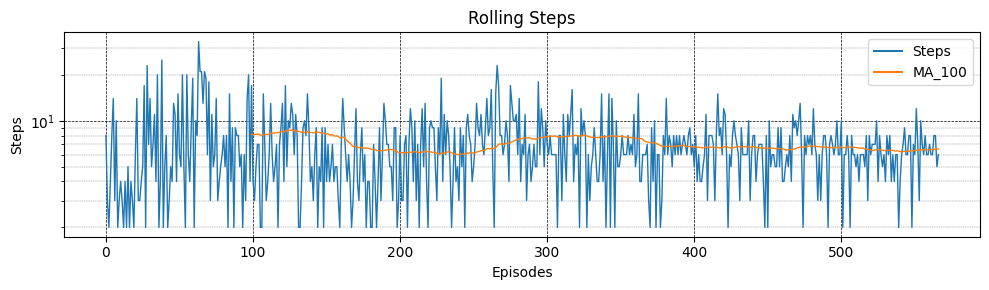

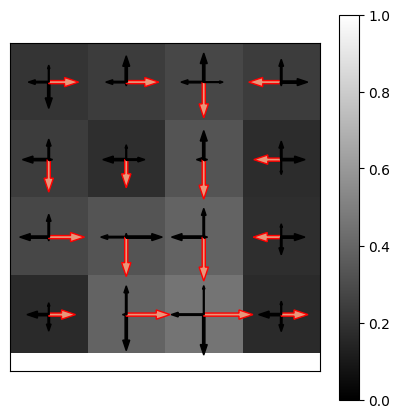

In [24]:
# Take extra training step and visualize the convergency of training steps moving average
agent5.n_episodes=500
agent5.dynamic_e_greedy = True
agent5.run(new_r=False, debugging_freq=10)
q_a = defaultdict(lambda: np.zeros(16))
for i in range(16):
    zs = np.zeros(16)
    zs[i] = 1
    q_a[i] = agent5.policy_net(np.array([zs])).numpy().flatten().tolist()
agent5.Q = q_a
agent5.rolling_plot()
_ = plot(agent5)

### 7.2.5. Test

In [26]:
# Reach the Optimal policy
agent5.epsilon = 0.
agent5.dynamic_e_greedy = False
test(agent5)

Testing episode:  0 /10 (s,a)=(0,2) (s,a)=(1,2) (s,a)=(2,1) (s,a)=(6,1) (s,a)=(10,1) (s,a)=(14,2) success

Testing episode:  1 /10 (s,a)=(0,2) (s,a)=(1,2) (s,a)=(2,1) (s,a)=(6,1) (s,a)=(10,1) (s,a)=(14,2) success

Testing episode:  2 /10 (s,a)=(0,2) (s,a)=(1,2) (s,a)=(2,1) (s,a)=(6,1) (s,a)=(10,1) (s,a)=(14,2) success

Testing episode:  3 /10 (s,a)=(0,2) (s,a)=(1,2) (s,a)=(2,1) (s,a)=(6,1) (s,a)=(10,1) (s,a)=(14,2) success

Testing episode:  4 /10 (s,a)=(0,2) (s,a)=(1,2) (s,a)=(2,1) (s,a)=(6,1) (s,a)=(10,1) (s,a)=(14,2) success

Testing episode:  5 /10 (s,a)=(0,2) (s,a)=(1,2) (s,a)=(2,1) (s,a)=(6,1) (s,a)=(10,1) (s,a)=(14,2) success

Testing episode:  6 /10 (s,a)=(0,2) (s,a)=(1,2) (s,a)=(2,1) (s,a)=(6,1) (s,a)=(10,1) (s,a)=(14,2) success

Testing episode:  7 /10 (s,a)=(0,2) (s,a)=(1,2) (s,a)=(2,1) (s,a)=(6,1) (s,a)=(10,1) (s,a)=(14,2) success

Testing episode:  8 /10 (s,a)=(0,2) (s,a)=(1,2) (s,a)=(2,1) (s,a)=(6,1) (s,a)=(10,1) (s,a)=(14,2) success

Testing episode:  9 /10 (s,a)=(0,2) (

## 7.3. Q-Learning on FrozenLake

In [30]:
env = EnvFrozenLake(state_def="scalar")
agent6 = QAgent(env, n_episodes=5000, n_steps=10, gamma=0.9, alpha=0.9, epsilon=None,
                epsilon_start=0.9, epsilon_end=0.2, epsilon_decay=2.0e+04, 
                checkpoint_name="policy2", )

### 7.3.1. No success rewards got

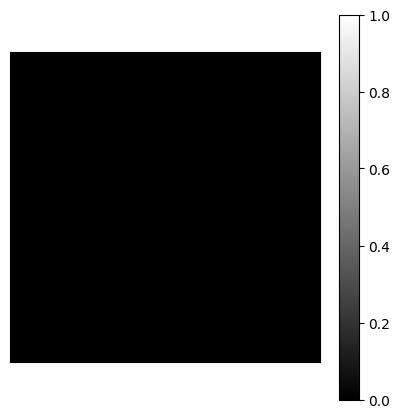

In [31]:
agent6.n_episodes = 10
agent6.dynamic_e_greedy = True
agent6.run(new_r=False)
_ = plot(agent6)

### 7.3.2. Keep finding

[10/10000]: 7, 0.8950
[20/10000]: 10, 0.8923
[30/10000]: 6, 0.8903
[40/10000]: 9, 0.8878
[50/10000]: 4, 0.8858
[60/10000]: 2, 0.8833
[70/10000]: 8, 0.8812
[80/10000]: 4, 0.8792
[90/10000]: 10, 0.8763
[100/10000]: 9, 0.8738
[110/10000]: 8, 0.8711
[120/10000]: 3, 0.8690
[130/10000]: 2, 0.8671
[140/10000]: 8, 0.8645
[150/10000]: 10, 0.8616
[160/10000]: 5, 0.8599
[170/10000]: 2, 0.8580
[180/10000]: 7, 0.8556
[190/10000]: 10, 0.8534
[200/10000]: 7, 0.8514
[210/10000]: 3, 0.8491
[220/10000]: 8, 0.8467
[230/10000]: 6, 0.8442
[240/10000]: 8, 0.8415
[250/10000]: 4, 0.8394
[260/10000]: 3, 0.8374
[270/10000]: 6, 0.8351
success
got a reward


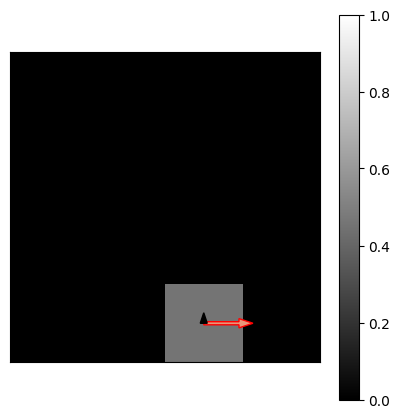

In [32]:
# Keep finding
agent6.n_episodes = 10000
agent6.dynamic_e_greedy = True
train(agent6)
_ = plot(agent6)

[10/10000]: 6, 0.8313
[20/10000]: 2, 0.8293
[30/10000]: 7, 0.8269
[40/10000]: 10, 0.8245
[50/10000]: 10, 0.8224
[60/10000]: 6, 0.8201
[70/10000]: 4, 0.8181
[80/10000]: 6, 0.8162
[90/10000]: 5, 0.8143
[100/10000]: 4, 0.8121
[110/10000]: 10, 0.8099
[120/10000]: 10, 0.8076
[130/10000]: 4, 0.8051
[140/10000]: 8, 0.8028
[150/10000]: 2, 0.8005
[160/10000]: 6, 0.7986
[170/10000]: 10, 0.7961
[180/10000]: 10, 0.7935
[190/10000]: 6, 0.7912
[200/10000]: 2, 0.7891
[210/10000]: 6, 0.7866
[220/10000]: 10, 0.7843
[230/10000]: 4, 0.7829
[240/10000]: 10, 0.7807
[250/10000]: 10, 0.7786
[260/10000]: 3, 0.7769
[270/10000]: 10, 0.7746
[280/10000]: 9, 0.7724
[290/10000]: 10, 0.7704
[300/10000]: 10, 0.7681
[310/10000]: 10, 0.7655
[320/10000]: 10, 0.7635
[330/10000]: 4, 0.7620
[340/10000]: 4, 0.7601
[350/10000]: 5, 0.7581
[360/10000]: 10, 0.7563
[370/10000]: 10, 0.7542
[380/10000]: 10, 0.7518
[390/10000]: 10, 0.7499
[400/10000]: 5, 0.7476
[410/10000]: 2, 0.7456
[420/10000]: 6, 0.7436
[430/10000]: 10, 0.7415
[

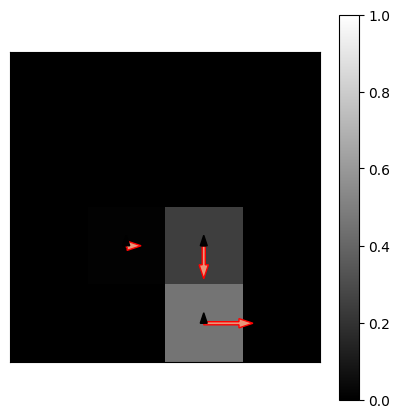

In [33]:
# Keep finding
agent6.n_episodes = 10000
agent6.dynamic_e_greedy = True
train(agent6)
_ = plot(agent6)

[10/10000]: 5, 0.7092
success
got a reward


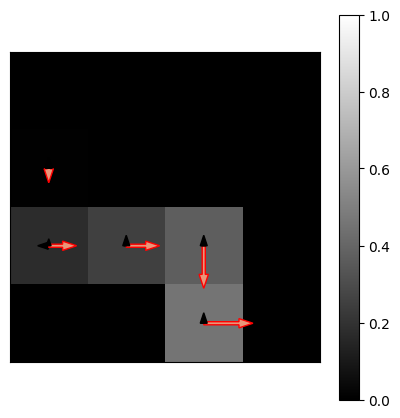

In [34]:
# Keep finding
agent6.n_episodes = 10000
agent6.dynamic_e_greedy = True
train(agent6)
_ = plot(agent6)

### 7.3.3. Oplimized policy reached

success
got a reward


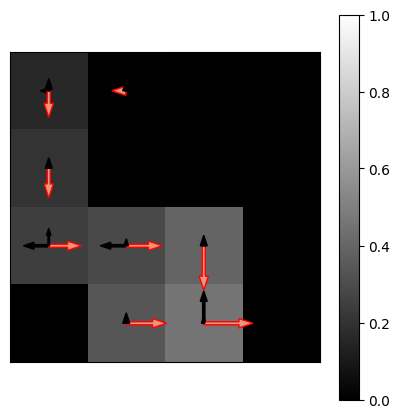

In [35]:
# Keep finding
agent6.n_episodes = 10000
agent6.dynamic_e_greedy = True
train(agent6)
_ = plot(agent6)

### 7.3.4. Visualizing training convergency after reaching optimal solution

success
[10/2000]: 2, 0.6889
success
success
[20/2000]: 5, 0.6872
success
success
[40/2000]: 8, 0.6840
success
success
success
success
[60/2000]: 2, 0.6806
success
[70/2000]: 2, 0.6789
success
success
success
success
success
[80/2000]: 6, 0.6773
success
[90/2000]: 4, 0.6762
success
success
[110/2000]: 9, 0.6728
success
[120/2000]: 2, 0.6711
success
success
[130/2000]: 2, 0.6696
success
success
[140/2000]: 9, 0.6681
success
success
success
[150/2000]: 9, 0.6664
[160/2000]: 2, 0.6650
[170/2000]: 7, 0.6637
[180/2000]: 3, 0.6622
success
[190/2000]: 5, 0.6606
success
success
[200/2000]: 4, 0.6589
success
success
success
[220/2000]: 7, 0.6557
[230/2000]: 5, 0.6543
success
[240/2000]: 6, 0.6529
success
[250/2000]: 3, 0.6516
success
[260/2000]: 5, 0.6504
success
[270/2000]: 9, 0.6488
success
[280/2000]: 6, 0.6477
success
success
[290/2000]: 8, 0.6459
success
success
success
success
[310/2000]: 6, 0.6426
success
success
[330/2000]: 2, 0.6397
[340/2000]: 2, 0.6384
success
success
[350/2000]: 5, 

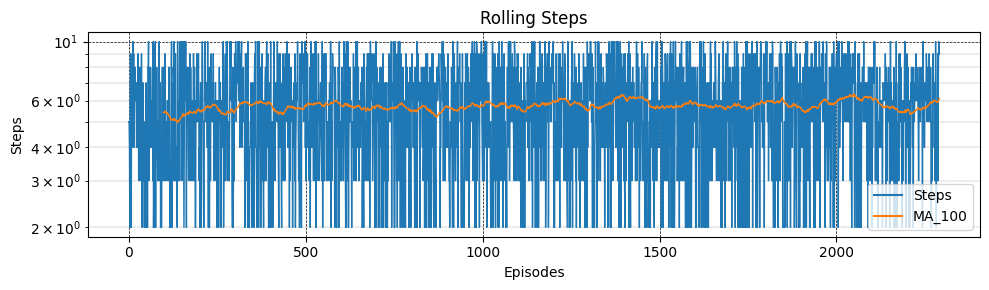

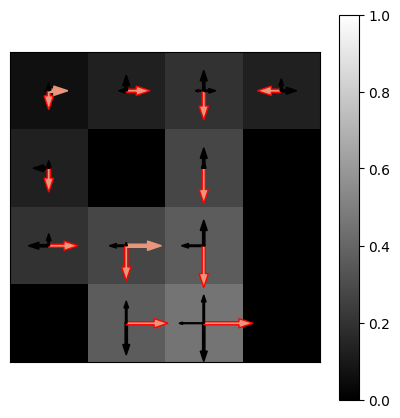

In [37]:
# Keep finding
agent6.n_episodes = 2000
agent6.dynamic_e_greedy = True
agent6.run(debugging_freq=10)
agent6.rolling_plot()
_ = plot(agent6)

### 7.3.5. Test

In [41]:
# lock epsilon to 0% eploration probability and test on trained DQN Agent
agent6.epsilon = 0.
agent6.dynamic_e_greedy = False
test(agent6)

Testing episode:  0 /10 (s,a)=(0,1) (s,a)=(4,1) (s,a)=(8,2) (s,a)=(9,1) (s,a)=(13,2) (s,a)=(14,2) success

Testing episode:  1 /10 (s,a)=(0,1) (s,a)=(4,1) (s,a)=(8,2) (s,a)=(9,1) (s,a)=(13,2) (s,a)=(14,2) success

Testing episode:  2 /10 (s,a)=(0,1) (s,a)=(4,1) (s,a)=(8,2) (s,a)=(9,1) (s,a)=(13,2) (s,a)=(14,2) success

Testing episode:  3 /10 (s,a)=(0,1) (s,a)=(4,1) (s,a)=(8,2) (s,a)=(9,1) (s,a)=(13,2) (s,a)=(14,2) success

Testing episode:  4 /10 (s,a)=(0,1) (s,a)=(4,1) (s,a)=(8,2) (s,a)=(9,1) (s,a)=(13,2) (s,a)=(14,2) success

Testing episode:  5 /10 (s,a)=(0,1) (s,a)=(4,1) (s,a)=(8,2) (s,a)=(9,1) (s,a)=(13,2) (s,a)=(14,2) success

Testing episode:  6 /10 (s,a)=(0,1) (s,a)=(4,1) (s,a)=(8,2) (s,a)=(9,1) (s,a)=(13,2) (s,a)=(14,2) success

Testing episode:  7 /10 (s,a)=(0,1) (s,a)=(4,1) (s,a)=(8,2) (s,a)=(9,1) (s,a)=(13,2) (s,a)=(14,2) success

Testing episode:  8 /10 (s,a)=(0,1) (s,a)=(4,1) (s,a)=(8,2) (s,a)=(9,1) (s,a)=(13,2) (s,a)=(14,2) success

Testing episode:  9 /10 (s,a)=(0,1) (

/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
